In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear
import configs
from eval import eval

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
exp_dir = '../trained_models/03_oja_sf_gradient_vis/'
p_files = os.listdir(exp_dir)

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

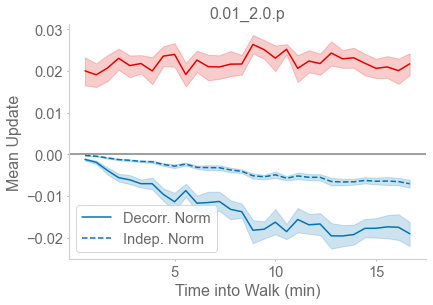

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

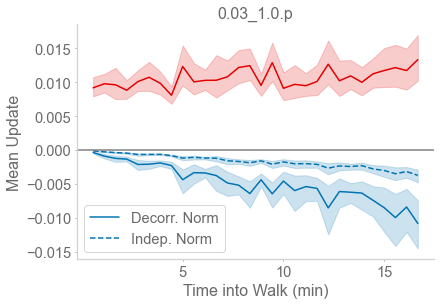

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

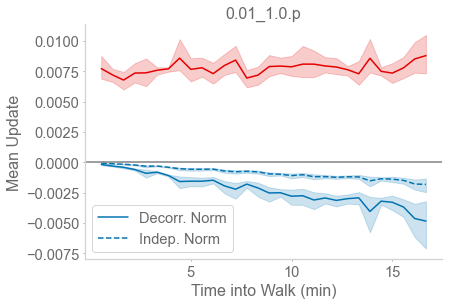

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

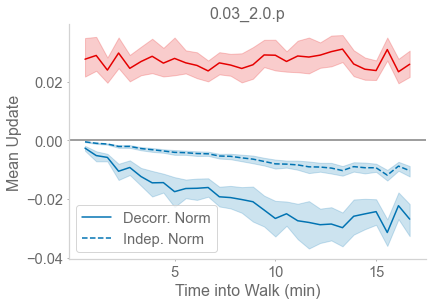

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

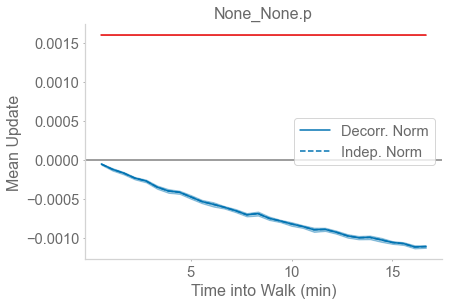

In [3]:
for p_file in p_files:
    with open(f'{exp_dir}{p_file}', 'rb') as f:
        results = pickle.load(f)['saved_grads']
    steps = []
    updates = []
    forgets = []
    oja_updates = []
    oja_forgets = []
    for key in results.keys():
        steps.extend(results[key]['steps'])
        updates.extend(results[key]['update'])
        forgets.extend(results[key]['forget'])
        oja_updates.extend(results[key]['oja_update'])
        oja_forgets.extend(results[key]['oja_forget'])
    forgets = [-f for f in forgets]
    oja_forgets = [-f for f in oja_forgets]
    fig, ax = plt.subplots(figsize=(6.4, 4.8*0.9))
    sns.lineplot(steps, updates, ax=ax, color='xkcd:red')
    sns.lineplot(steps, forgets, ax=ax, color='C0', label='Decorr. Norm')
    sns.lineplot(steps, oja_forgets, ax=ax, color='C0', linestyle='--', label='Indep. Norm')
    plt.axhline(0, color='gray')
    plt.xlabel('Time into Walk (min)')
    mins = [5, 10, 15]
    plt.xticks([_min*60*3 for _min in mins], mins)
    plt.ylabel('Mean Update')
    plt.title(p_file)
    plt.show()

In [67]:
from scipy.stats import pearsonr

0.01_2.0.p


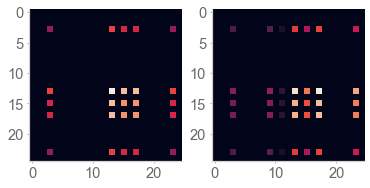

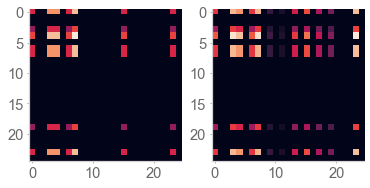

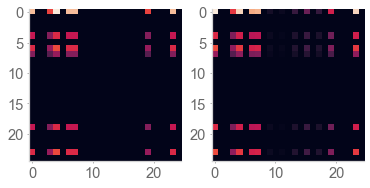

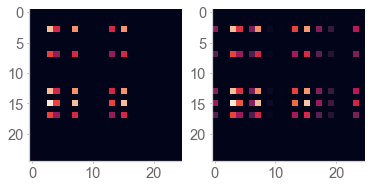

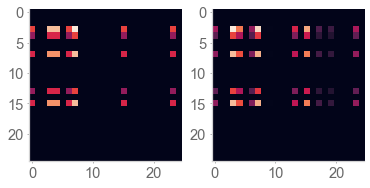

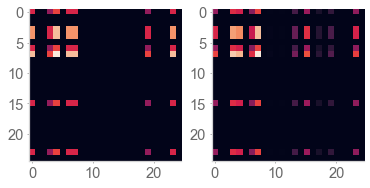

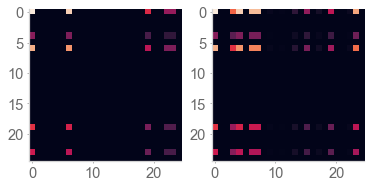

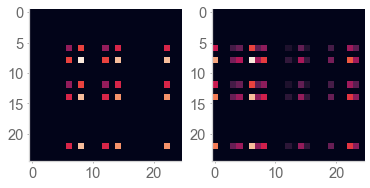

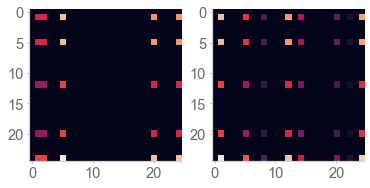

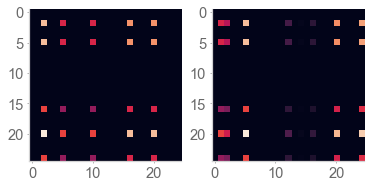

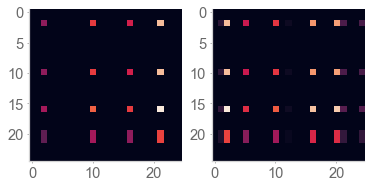

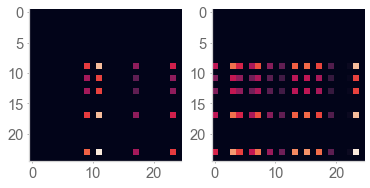

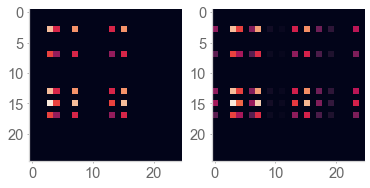

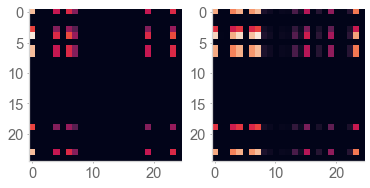

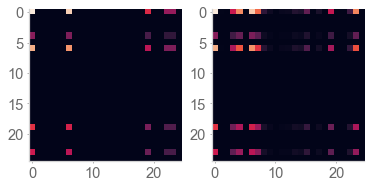

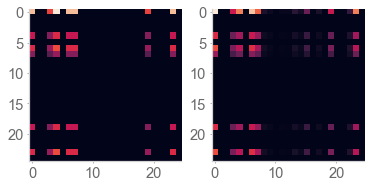

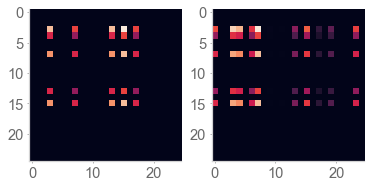

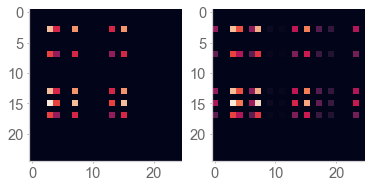

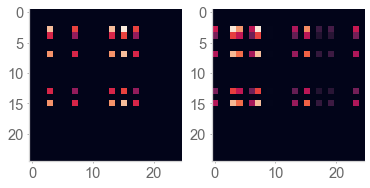

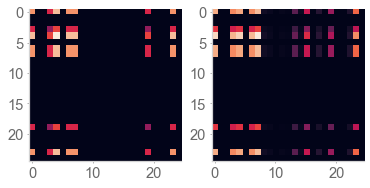

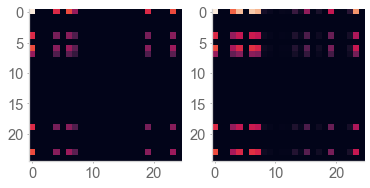

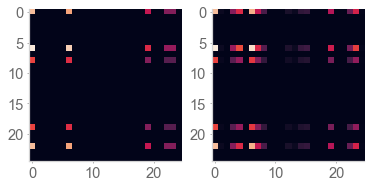

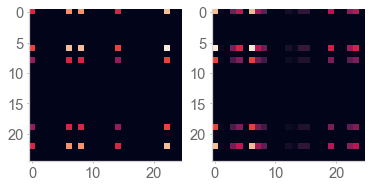

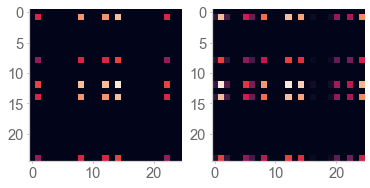

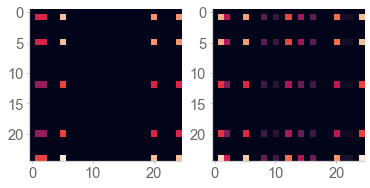

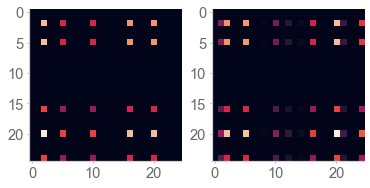

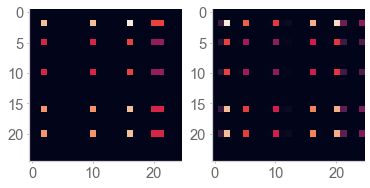

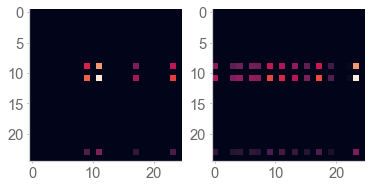

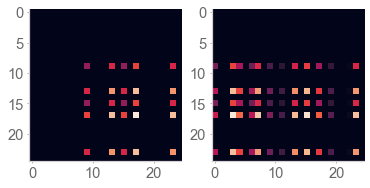

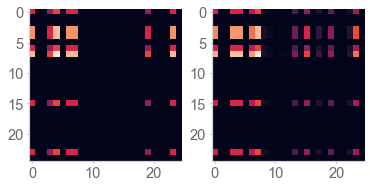

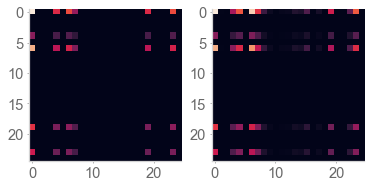

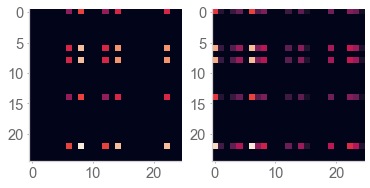

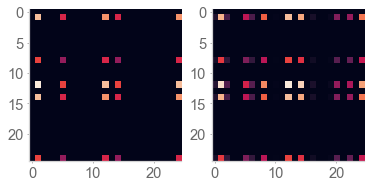

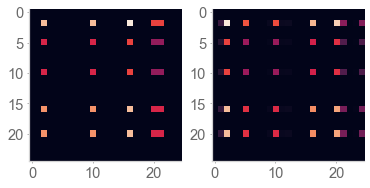

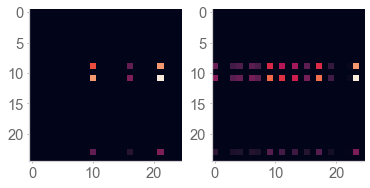

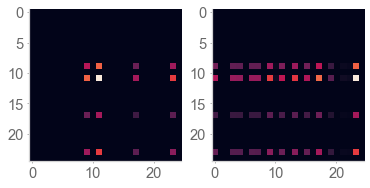

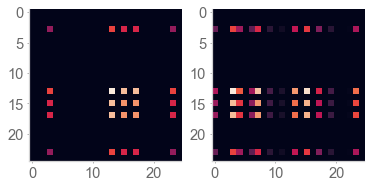

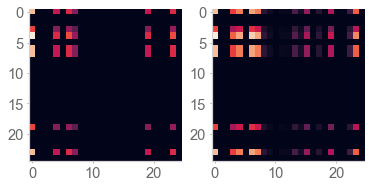

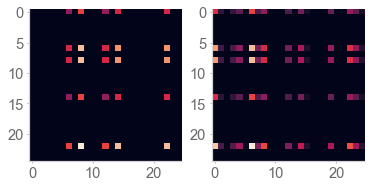

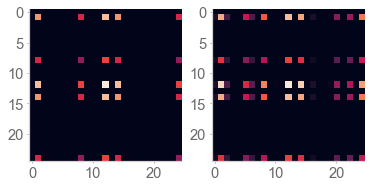

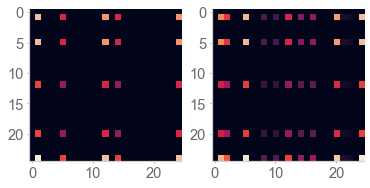

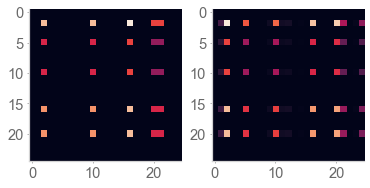

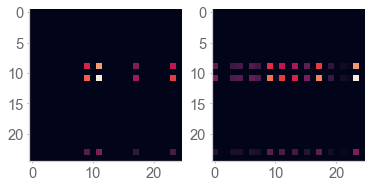

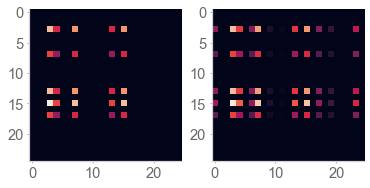

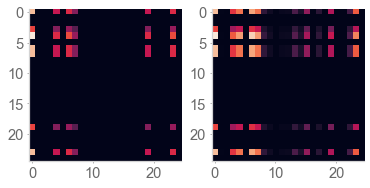

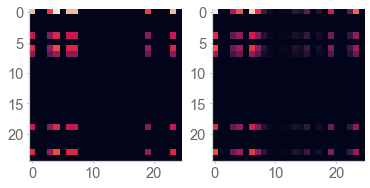

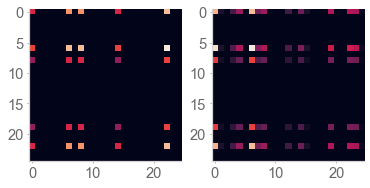

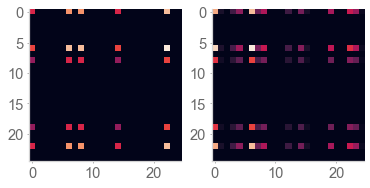

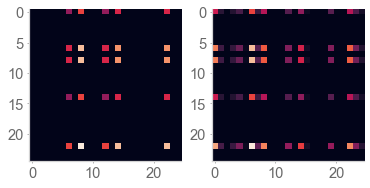

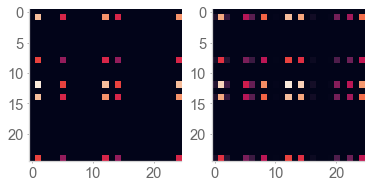

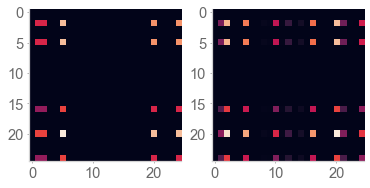

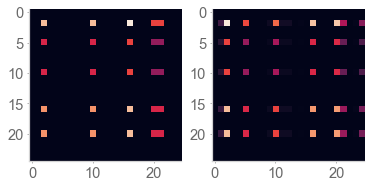

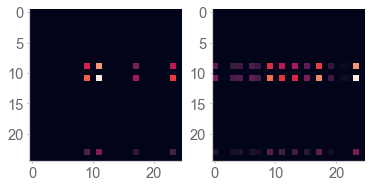

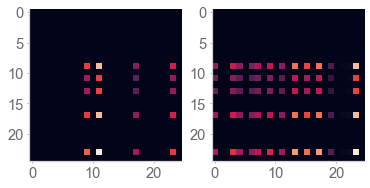

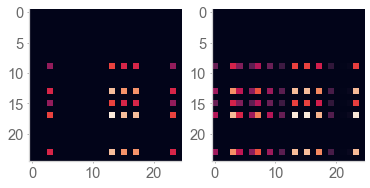

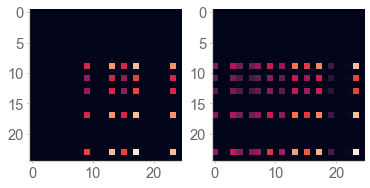

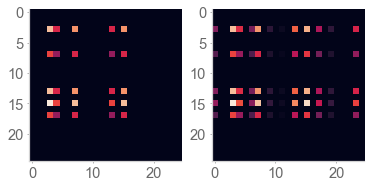

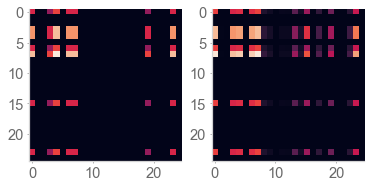

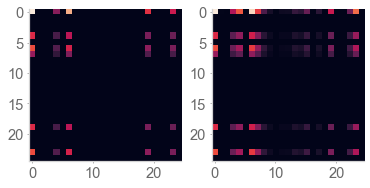

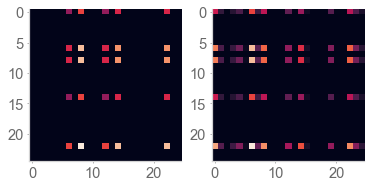

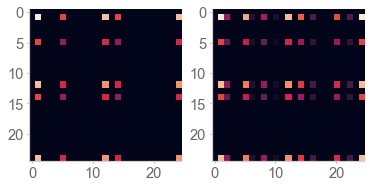

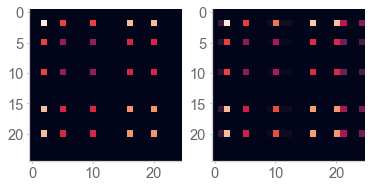

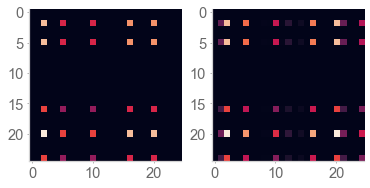

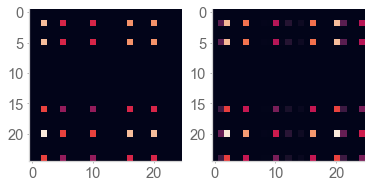

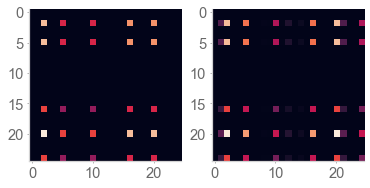

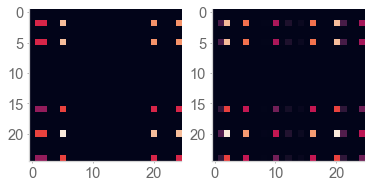

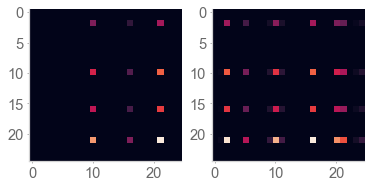

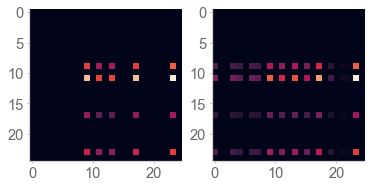

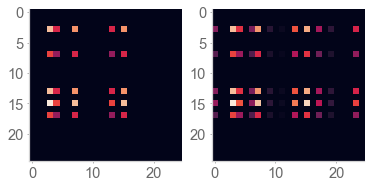

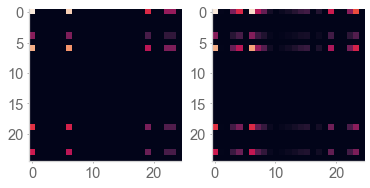

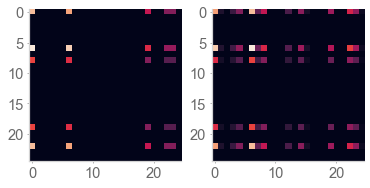

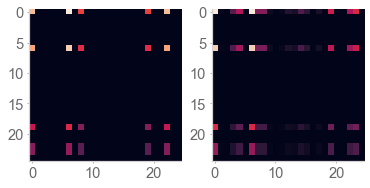

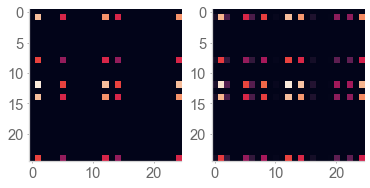

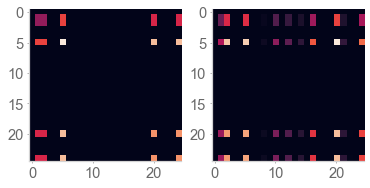

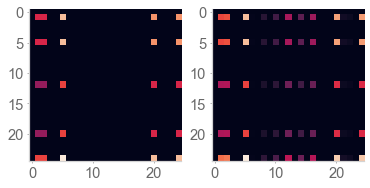

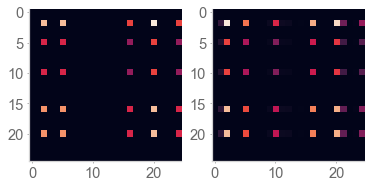

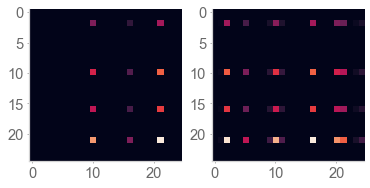

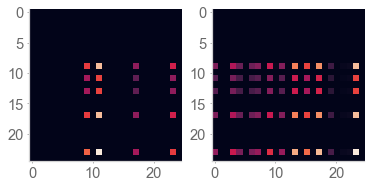

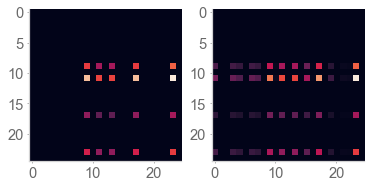

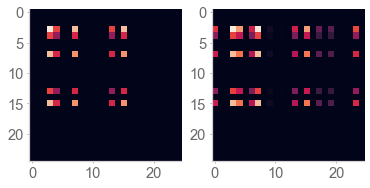

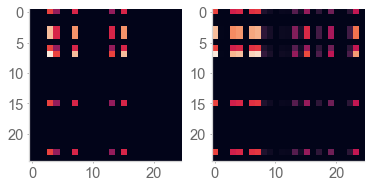

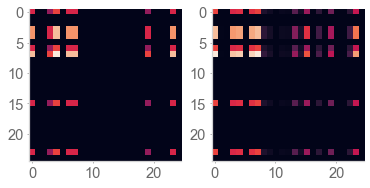

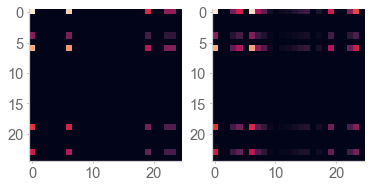

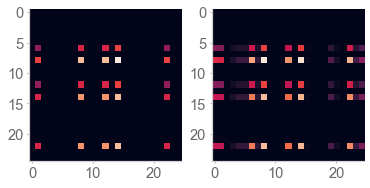

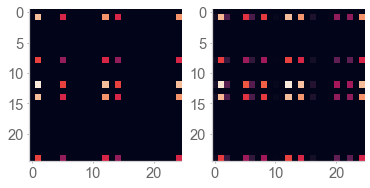

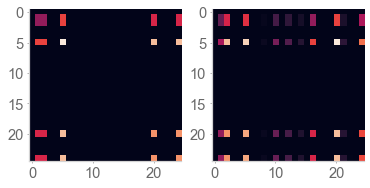

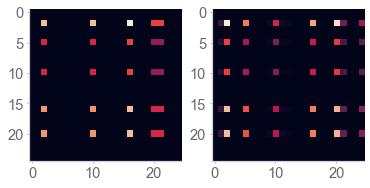

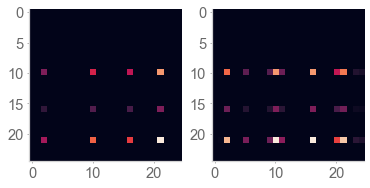

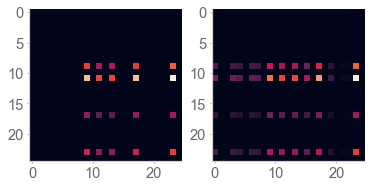

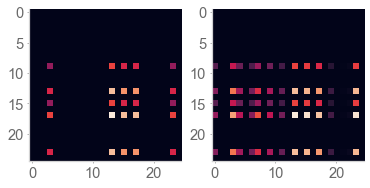

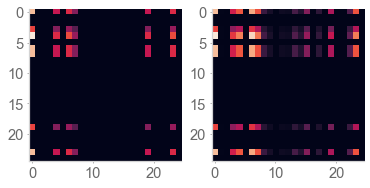

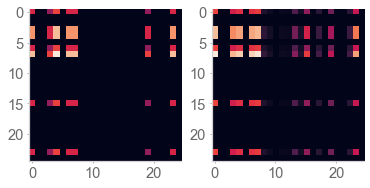

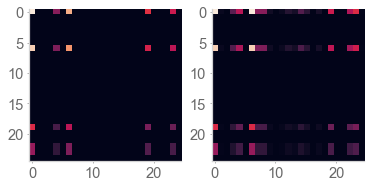

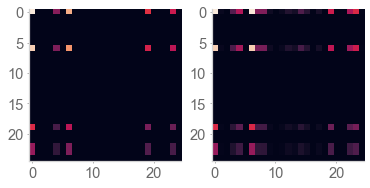

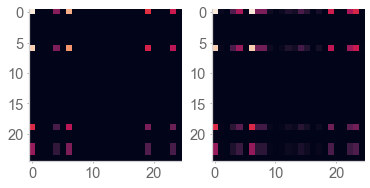

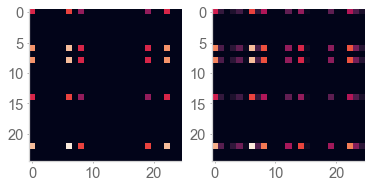

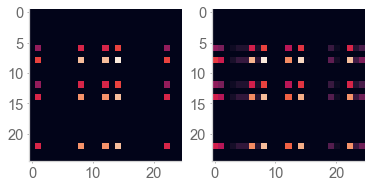

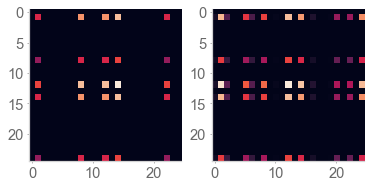

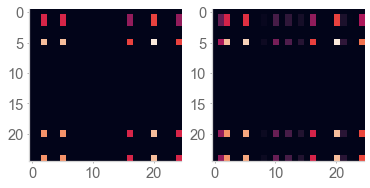

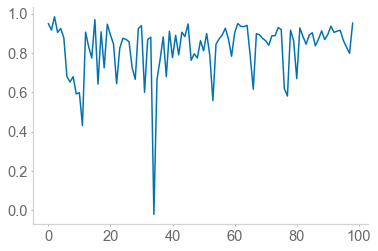





0.03_1.0.p


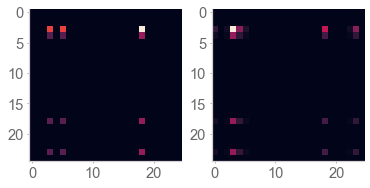

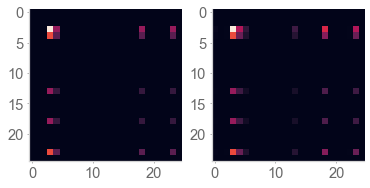

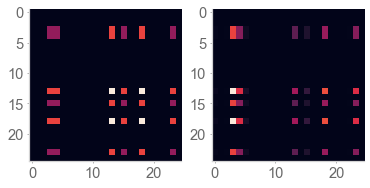

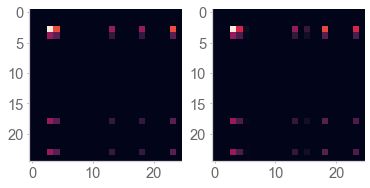

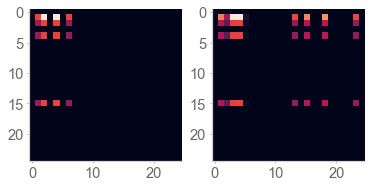

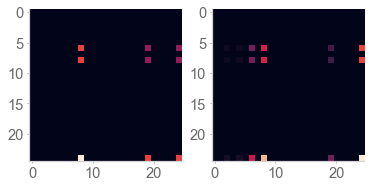

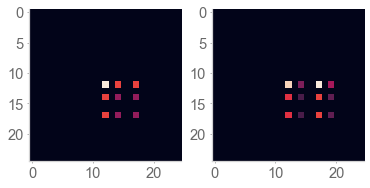

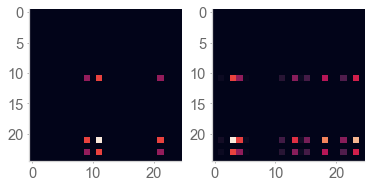

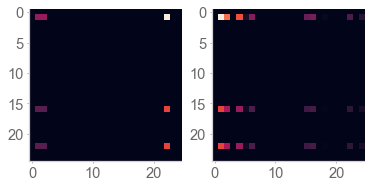

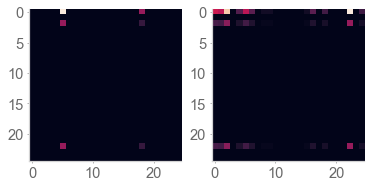

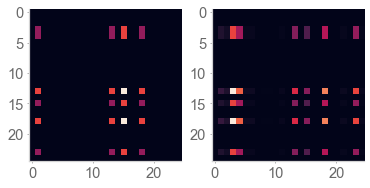

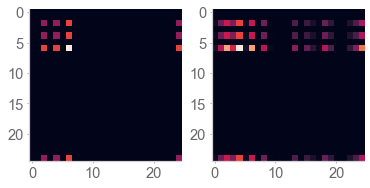

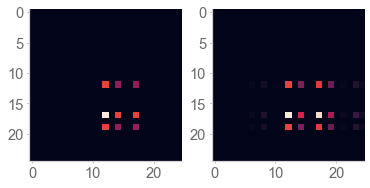

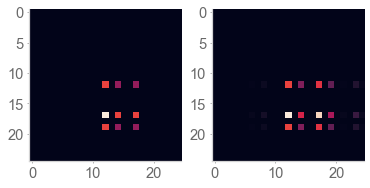

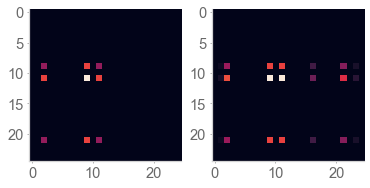

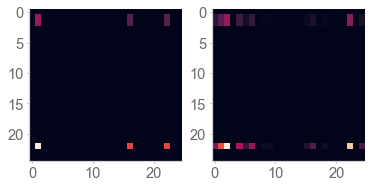

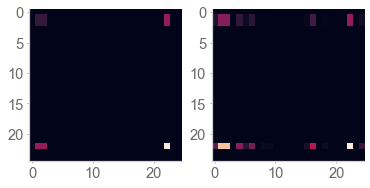

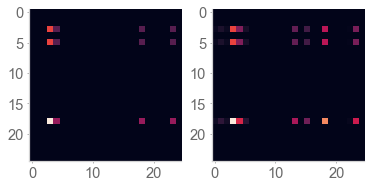

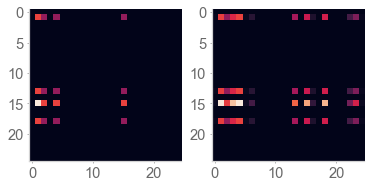

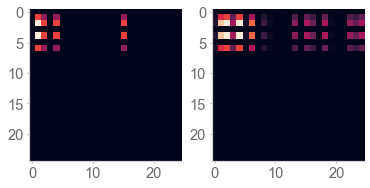

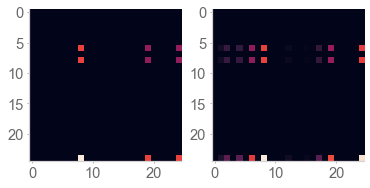

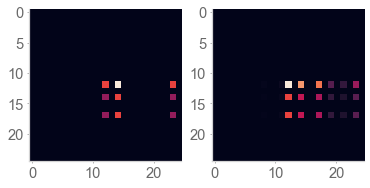

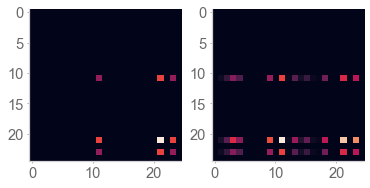

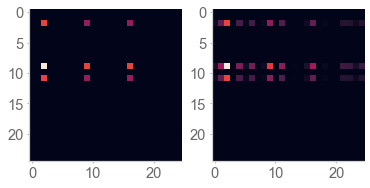

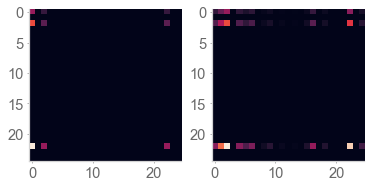

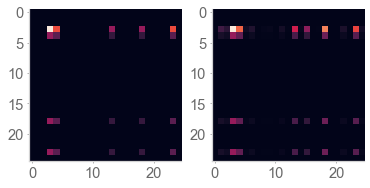

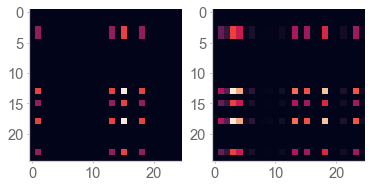

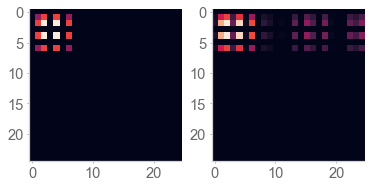

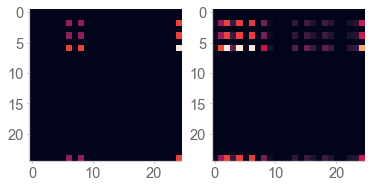

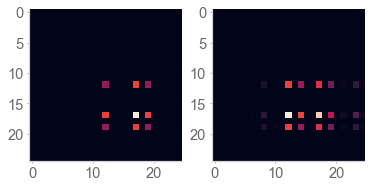

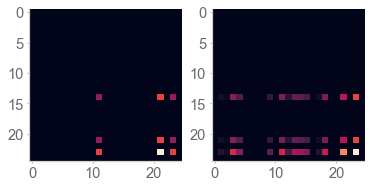

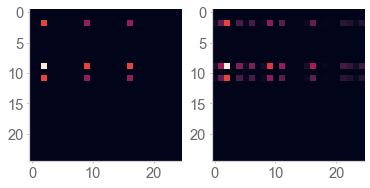

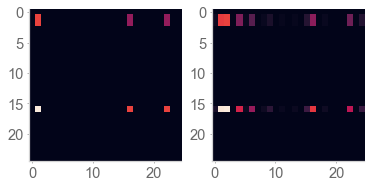

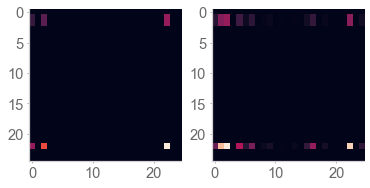

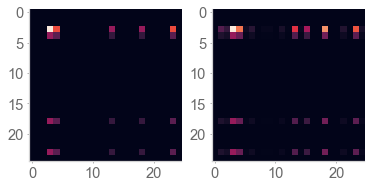

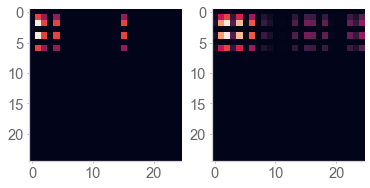

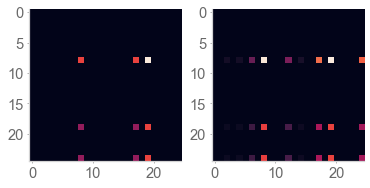

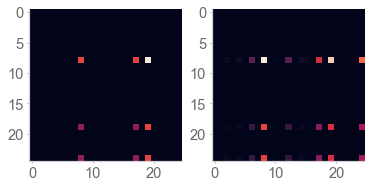

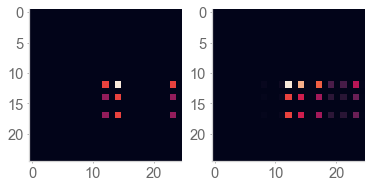

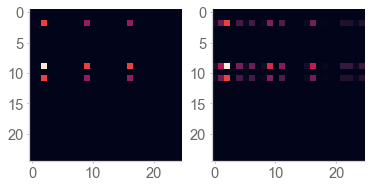

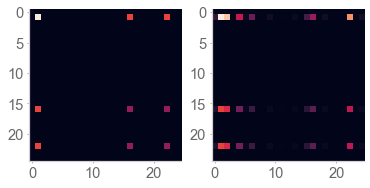

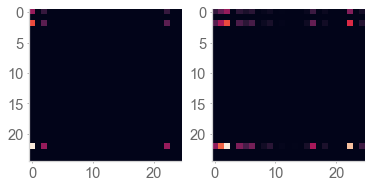

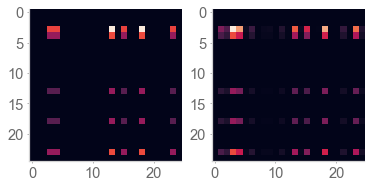

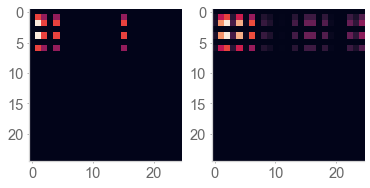

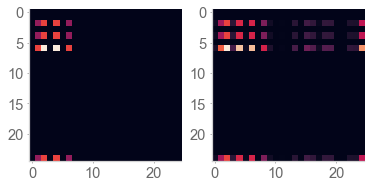

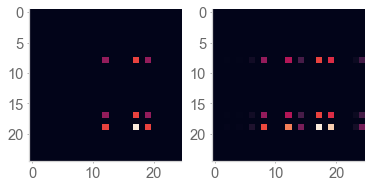

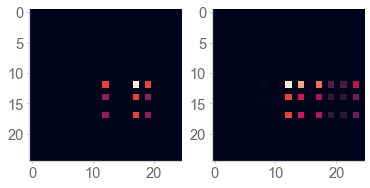

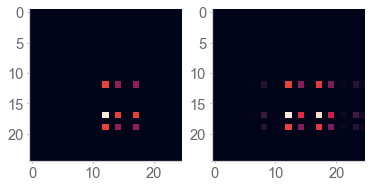

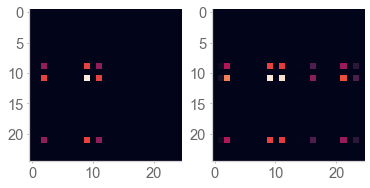

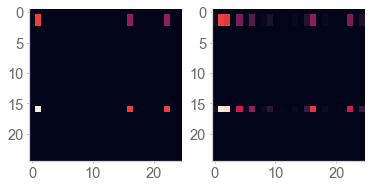

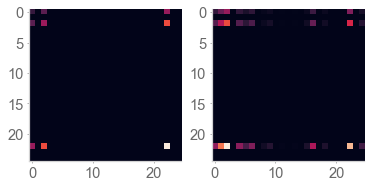

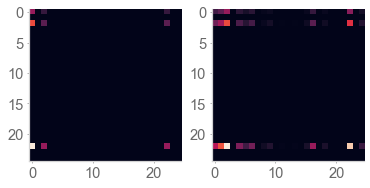

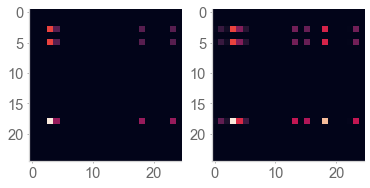

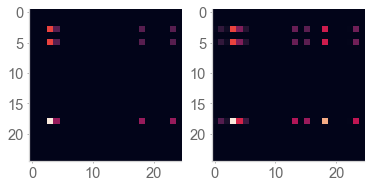

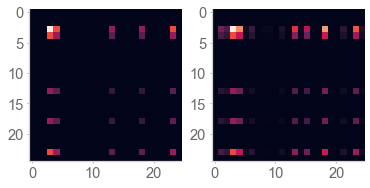

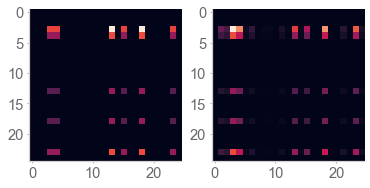

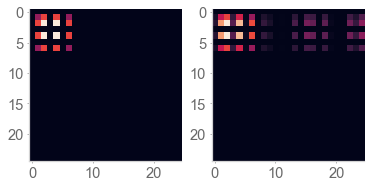

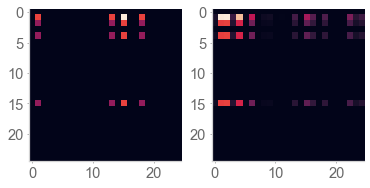

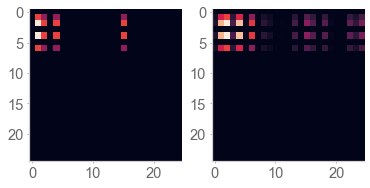

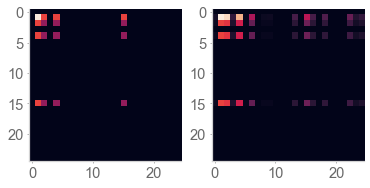

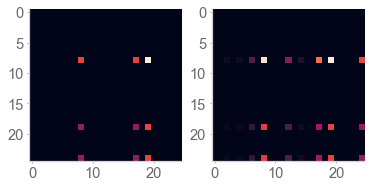

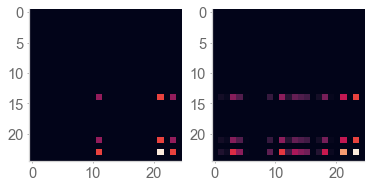

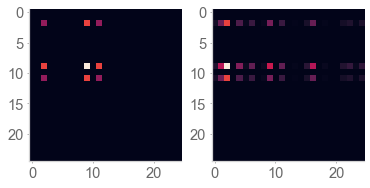

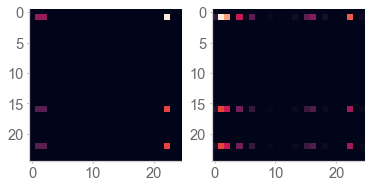

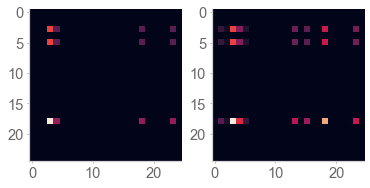

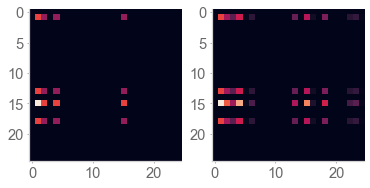

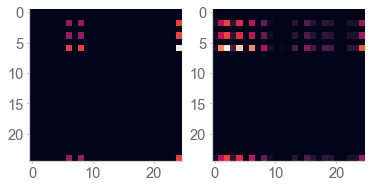

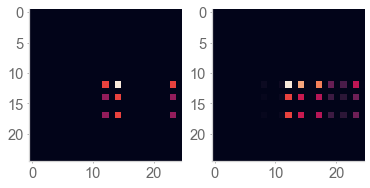

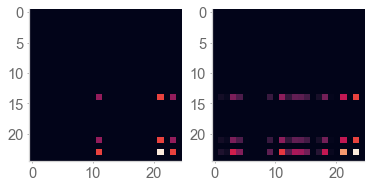

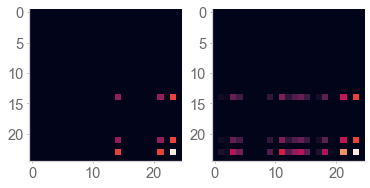

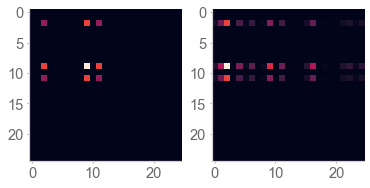

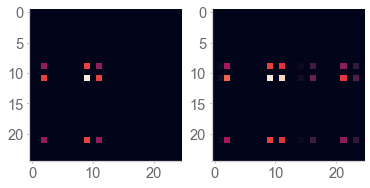

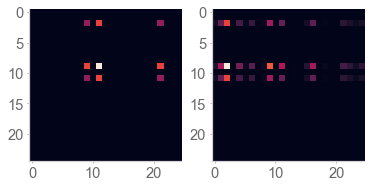

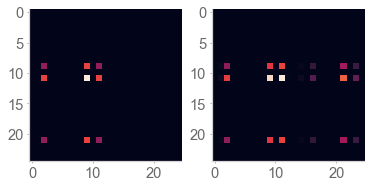

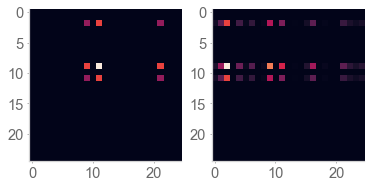

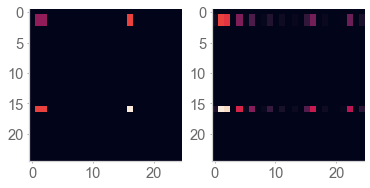

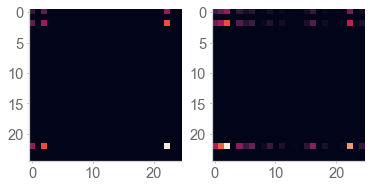

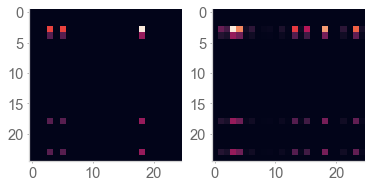

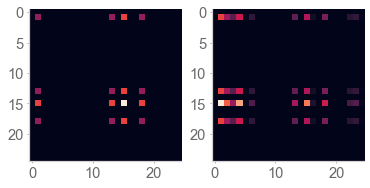

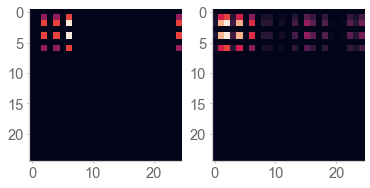

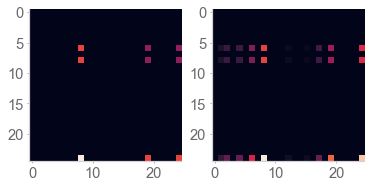

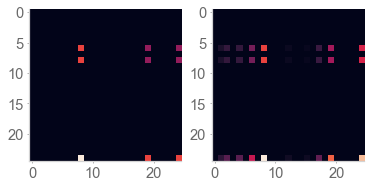

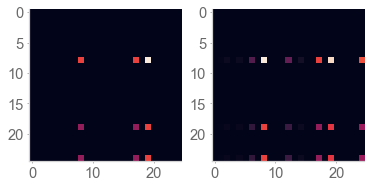

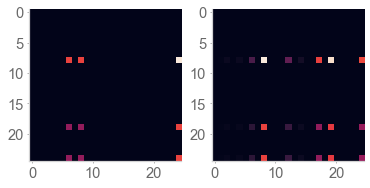

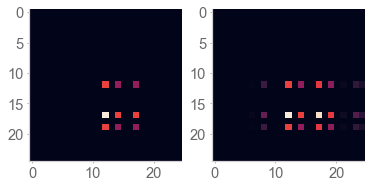

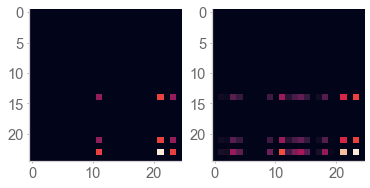

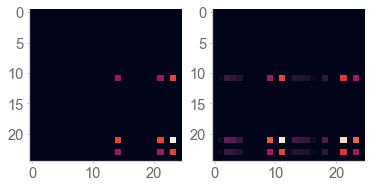

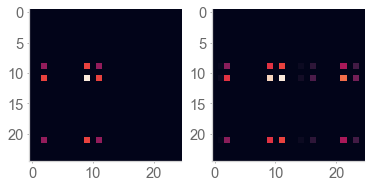

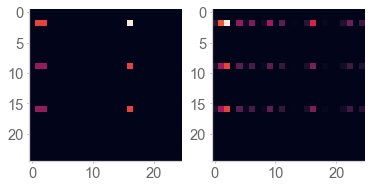

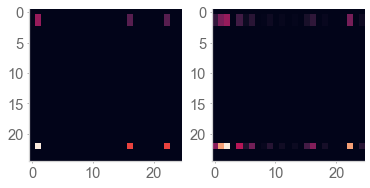

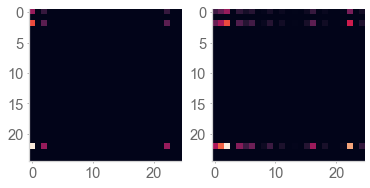

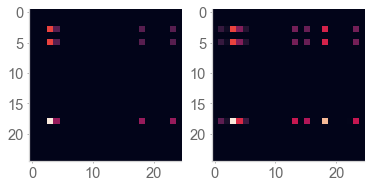

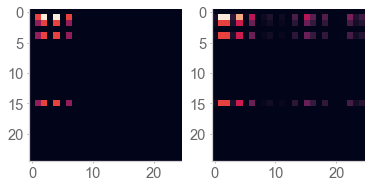

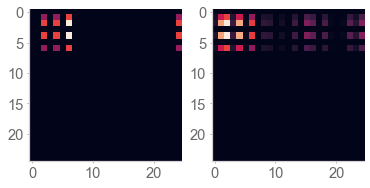

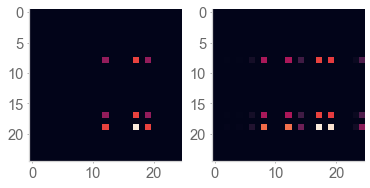

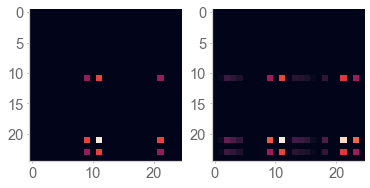

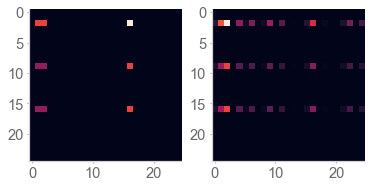

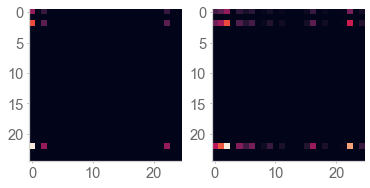

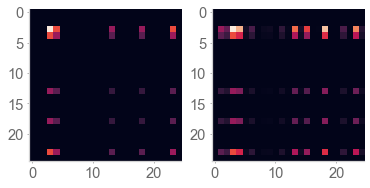

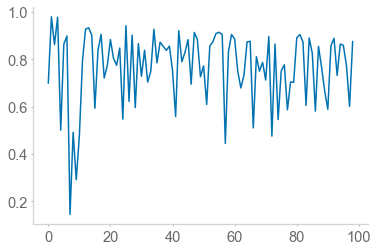





0.01_1.0.p


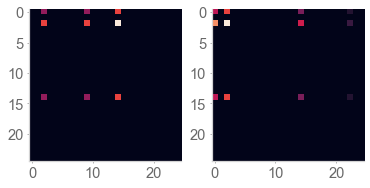

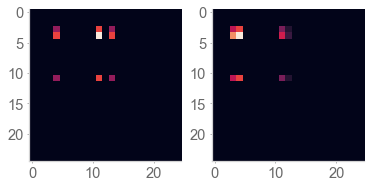

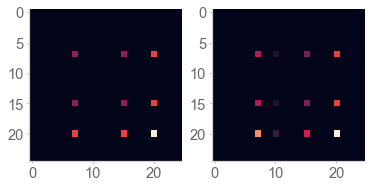

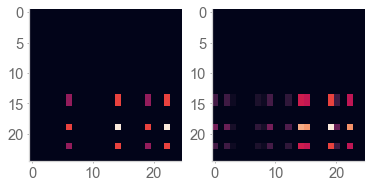

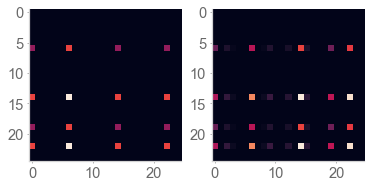

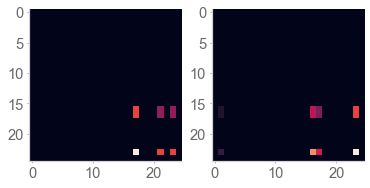

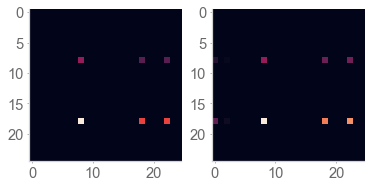

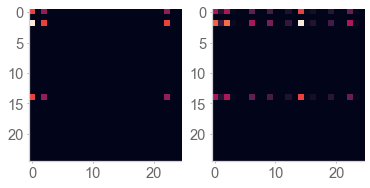

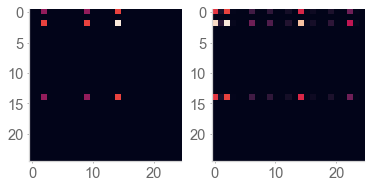

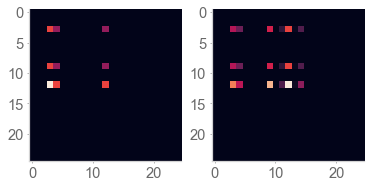

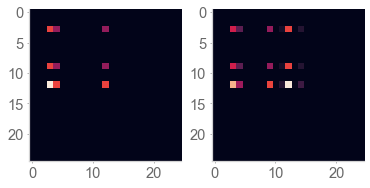

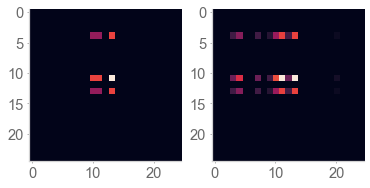

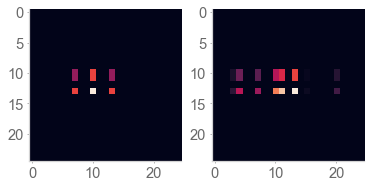

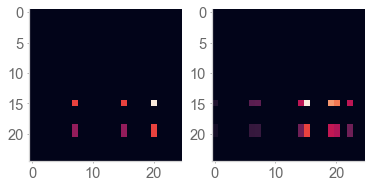

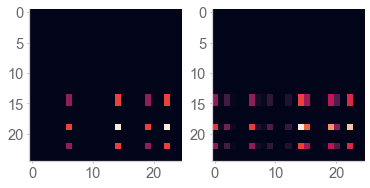

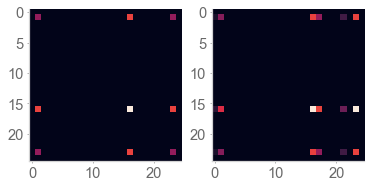

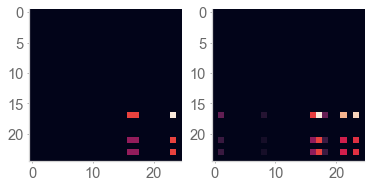

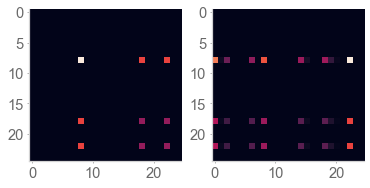

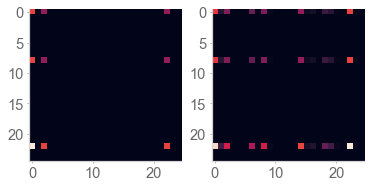

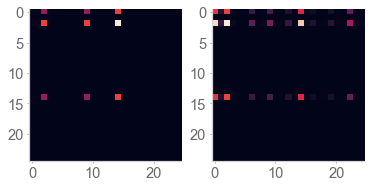

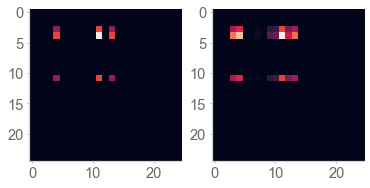

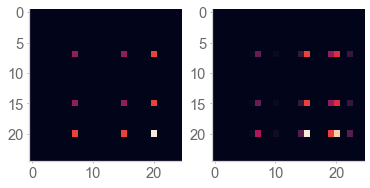

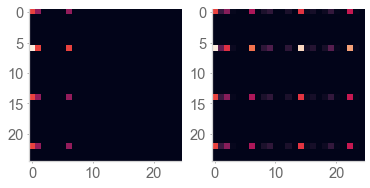

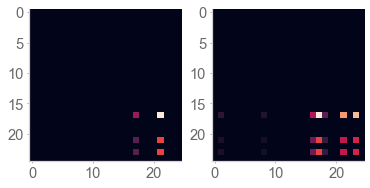

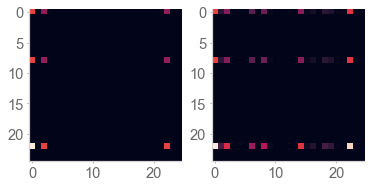

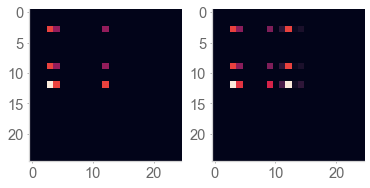

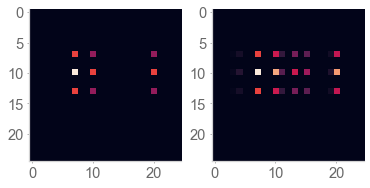

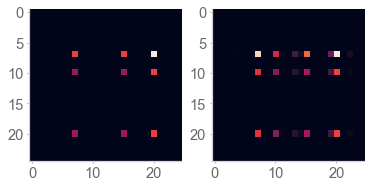

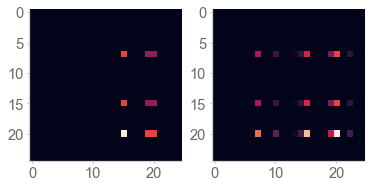

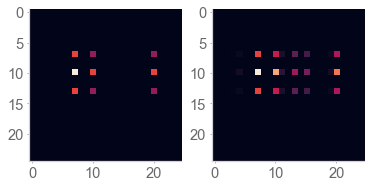

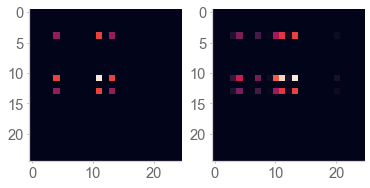

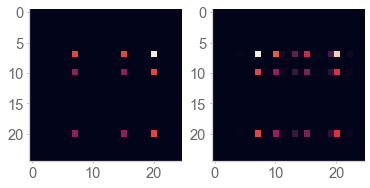

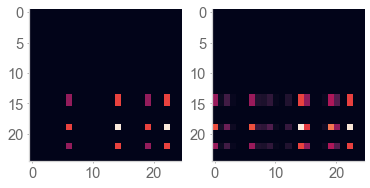

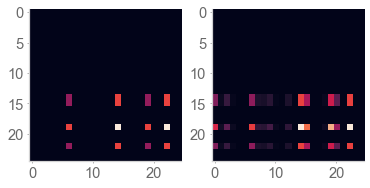

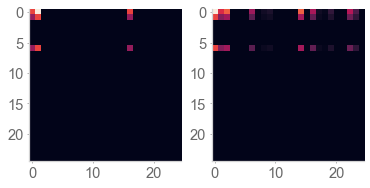

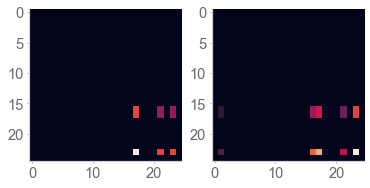

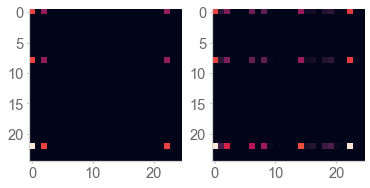

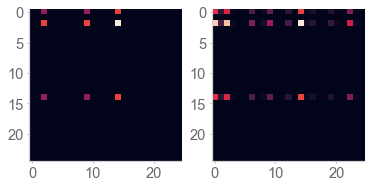

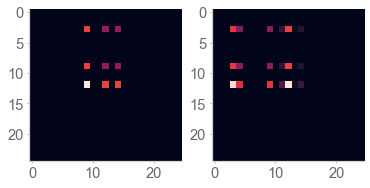

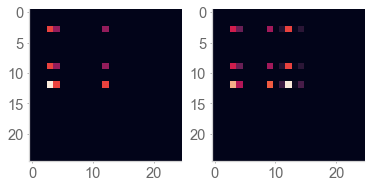

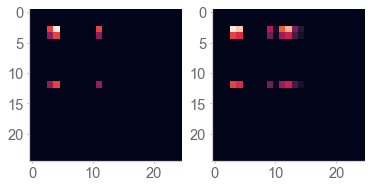

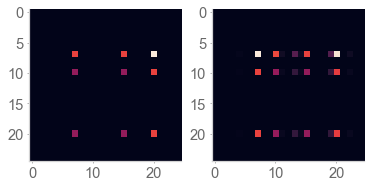

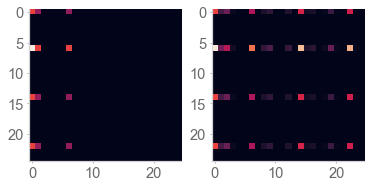

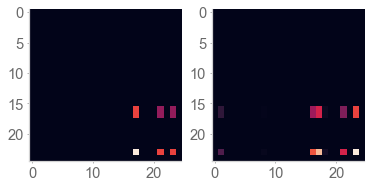

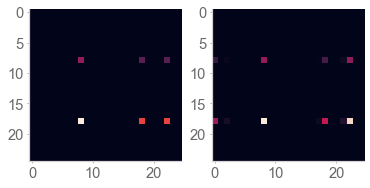

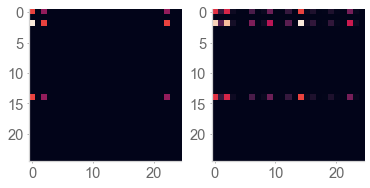

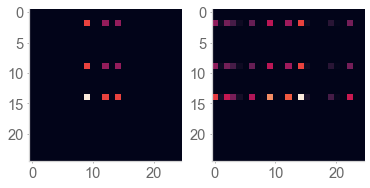

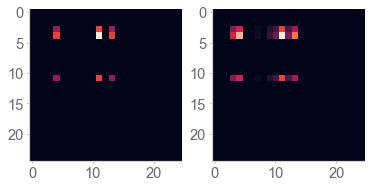

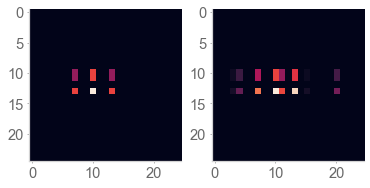

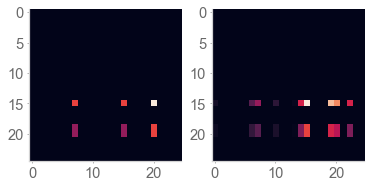

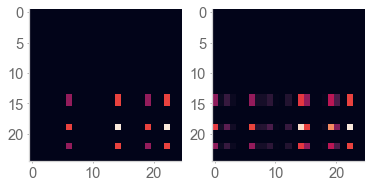

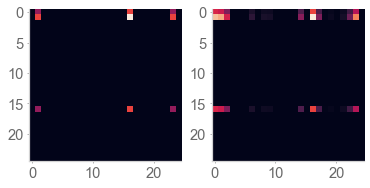

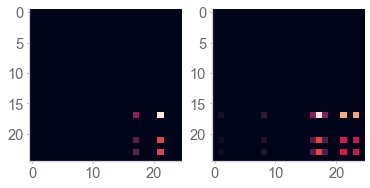

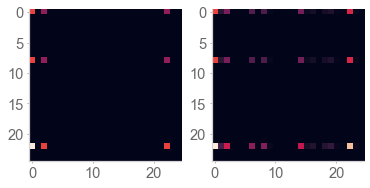

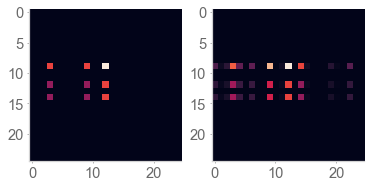

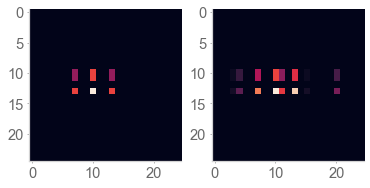

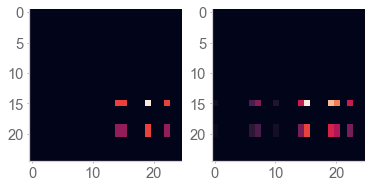

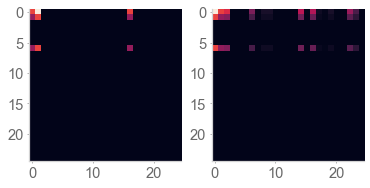

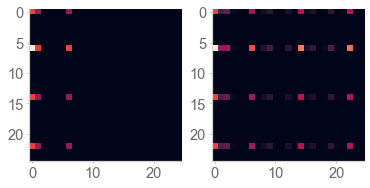

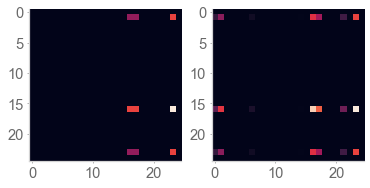

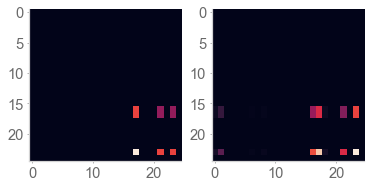

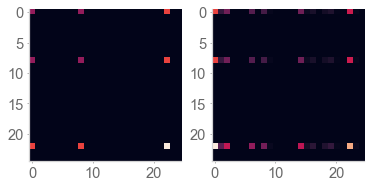

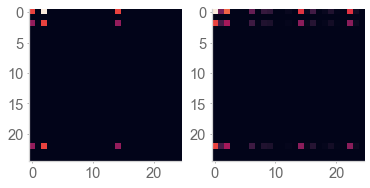

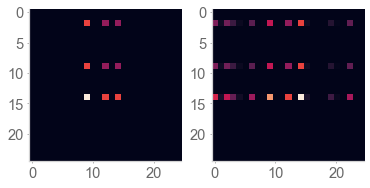

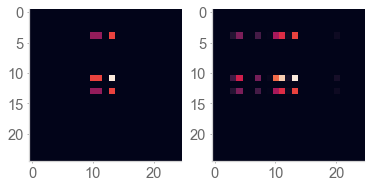

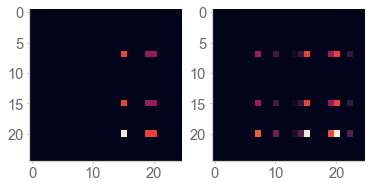

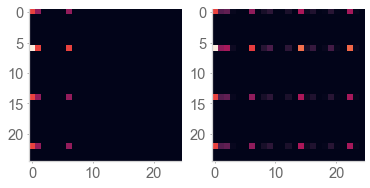

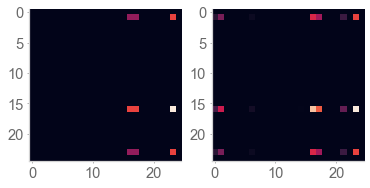

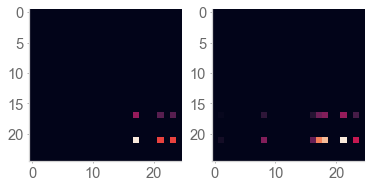

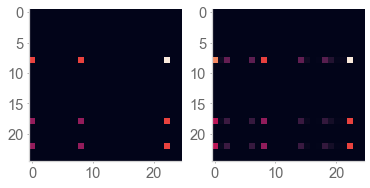

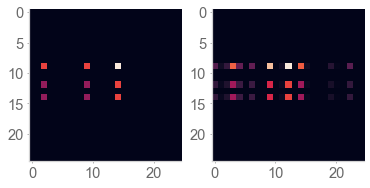

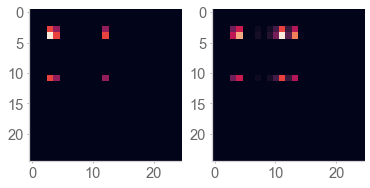

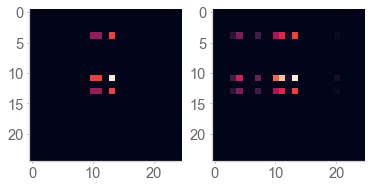

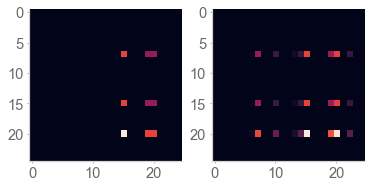

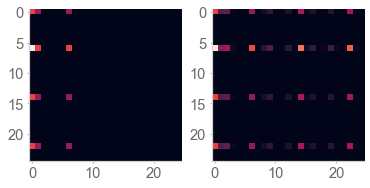

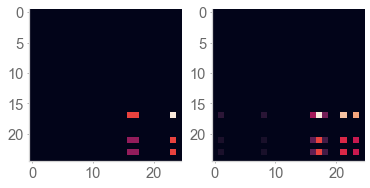

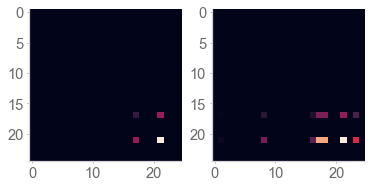

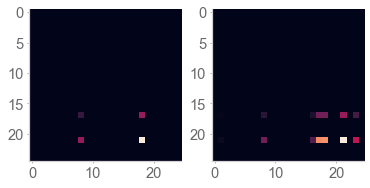

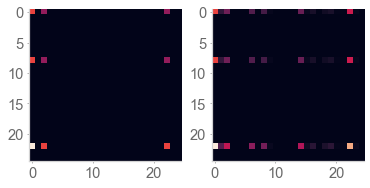

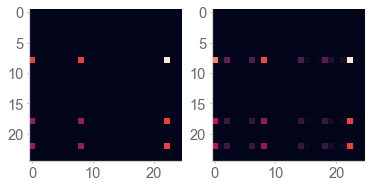

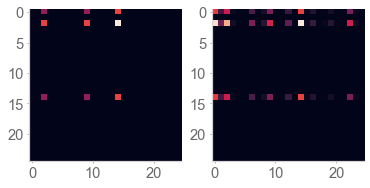

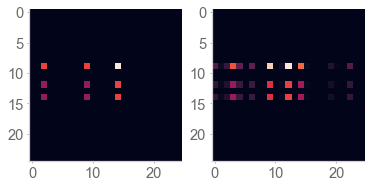

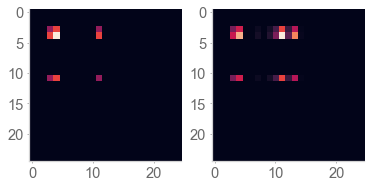

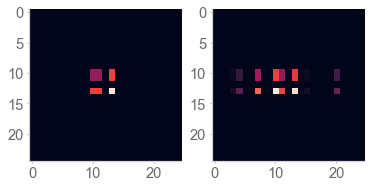

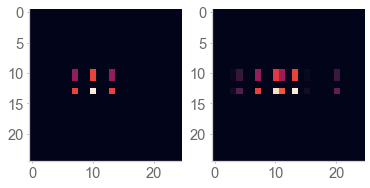

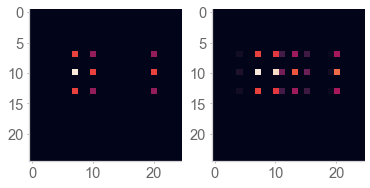

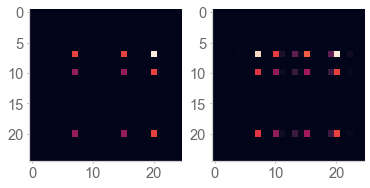

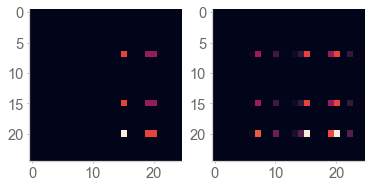

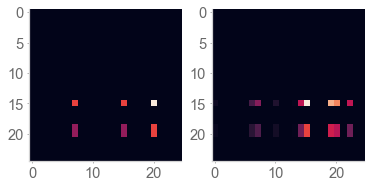

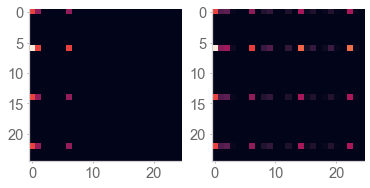

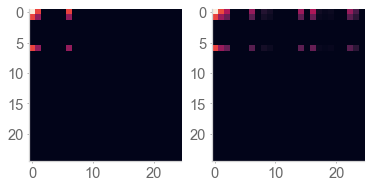

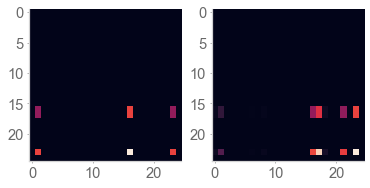

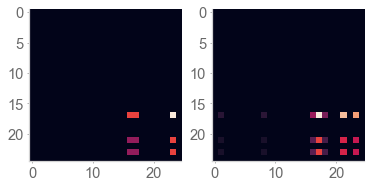

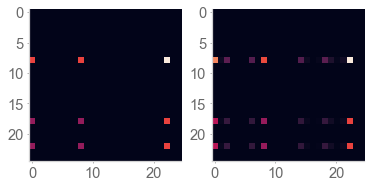

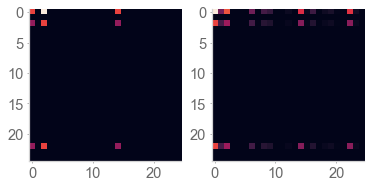

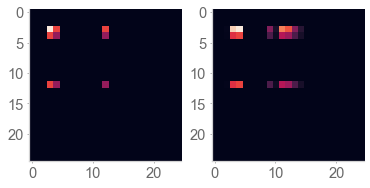

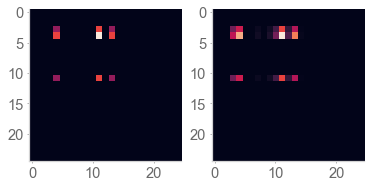

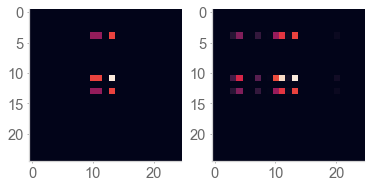

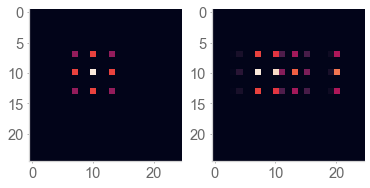

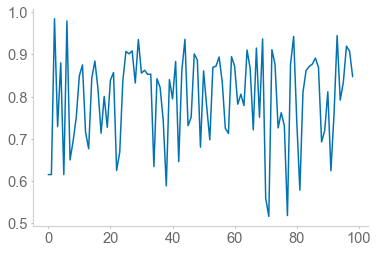





0.03_2.0.p


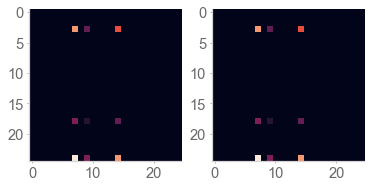

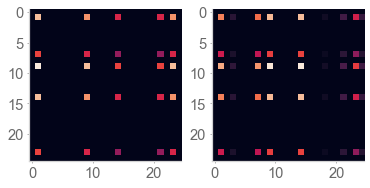

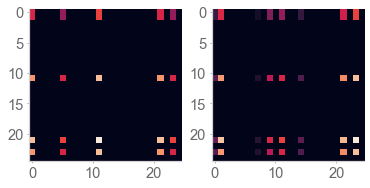

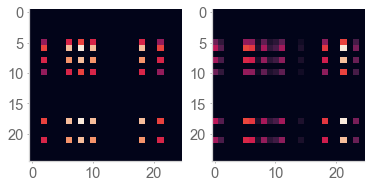

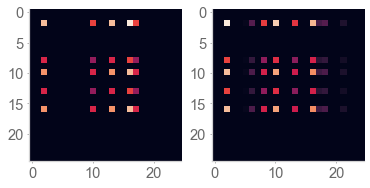

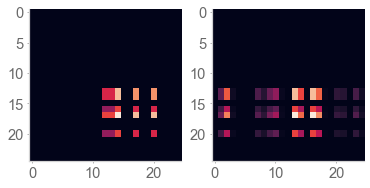

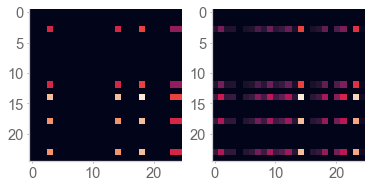

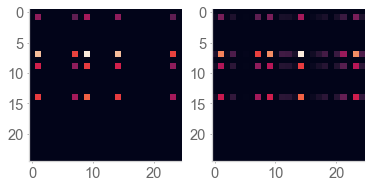

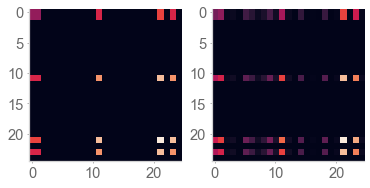

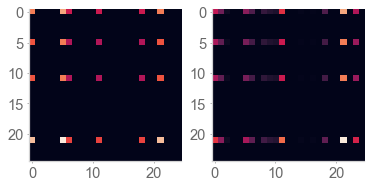

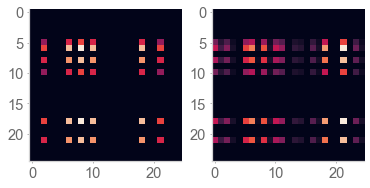

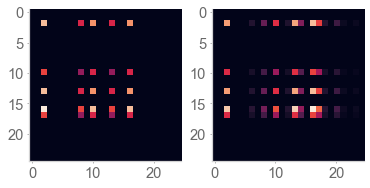

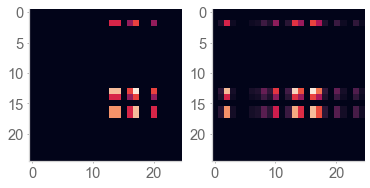

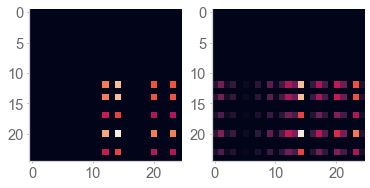

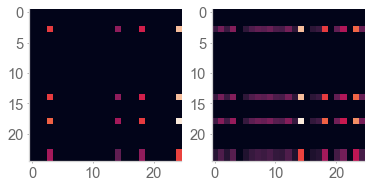

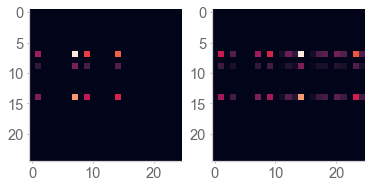

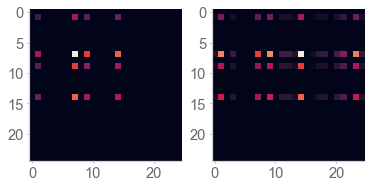

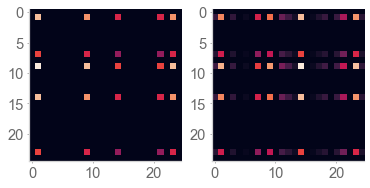

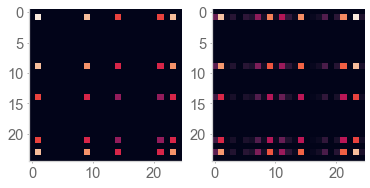

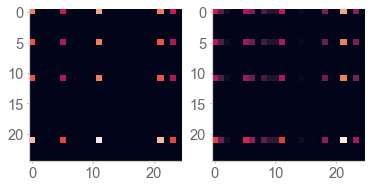

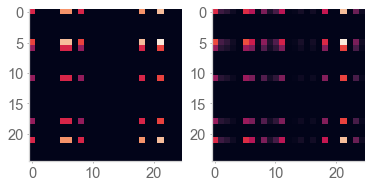

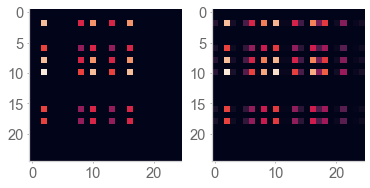

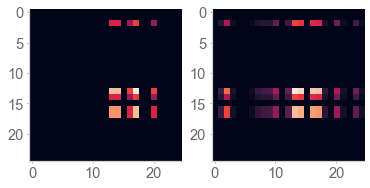

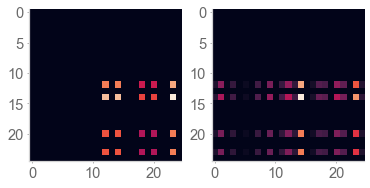

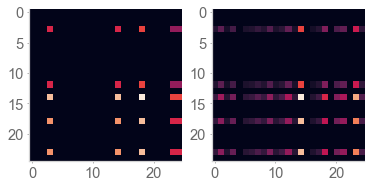

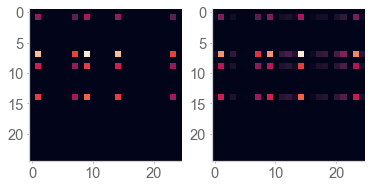

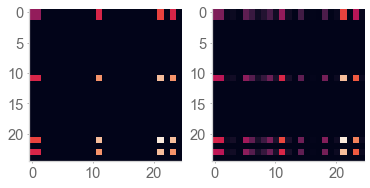

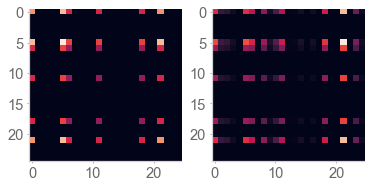

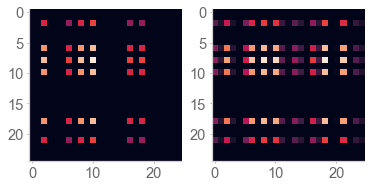

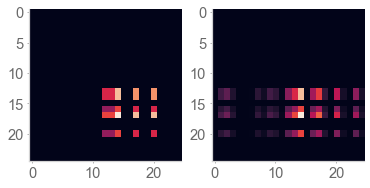

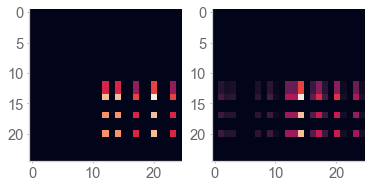

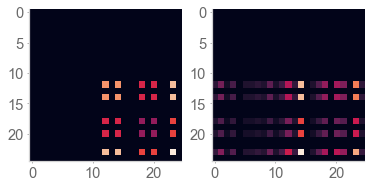

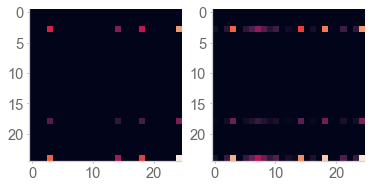

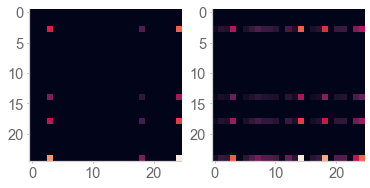

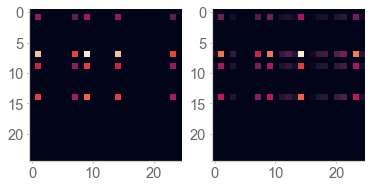

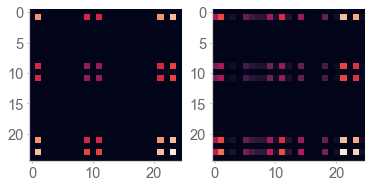

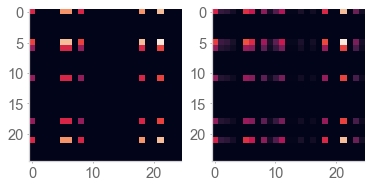

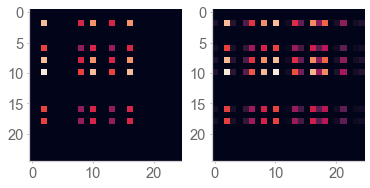

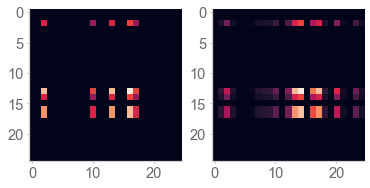

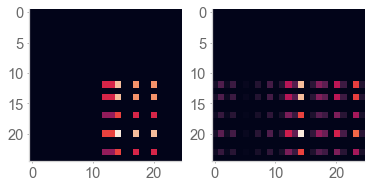

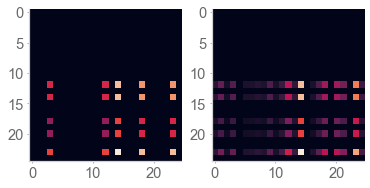

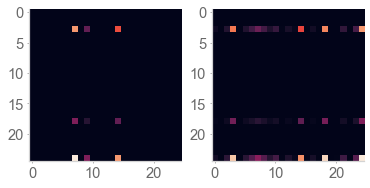

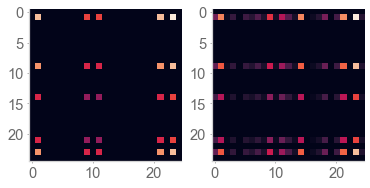

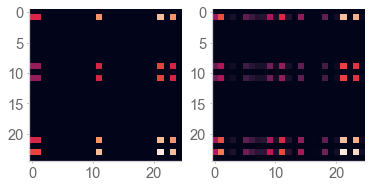

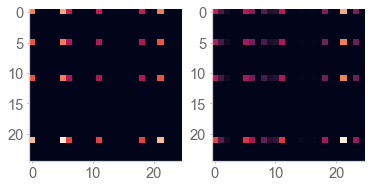

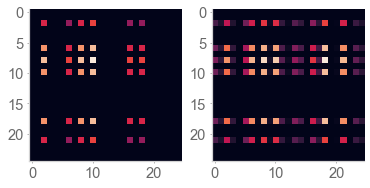

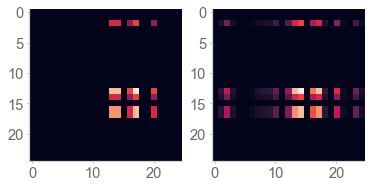

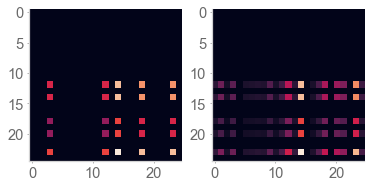

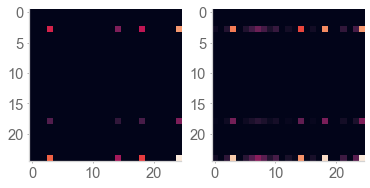

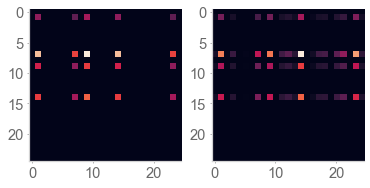

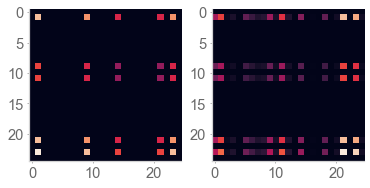

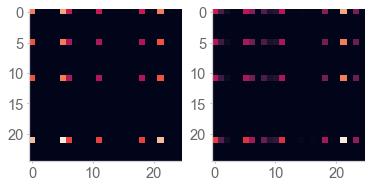

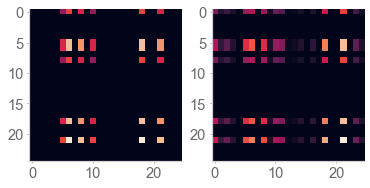

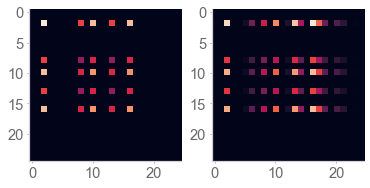

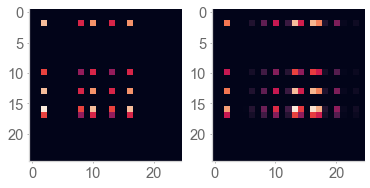

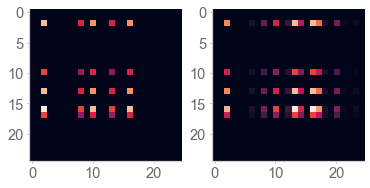

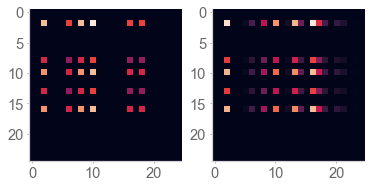

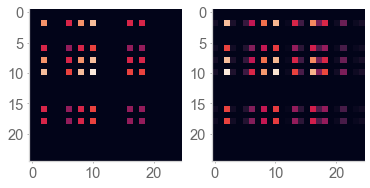

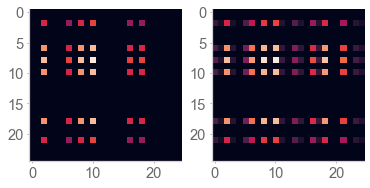

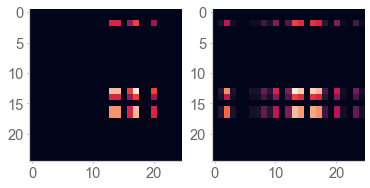

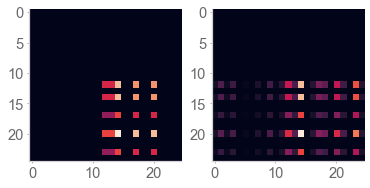

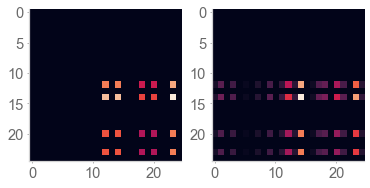

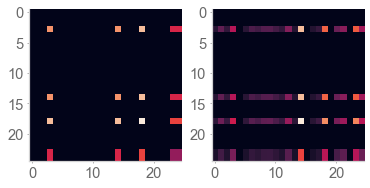

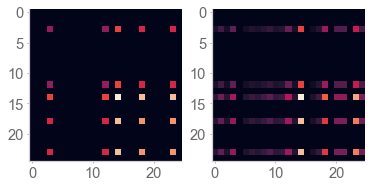

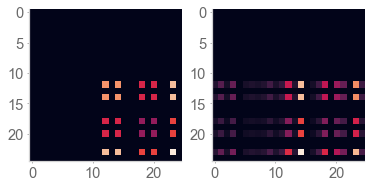

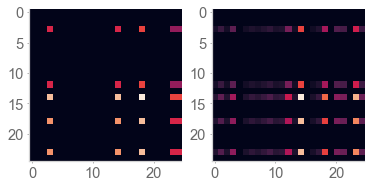

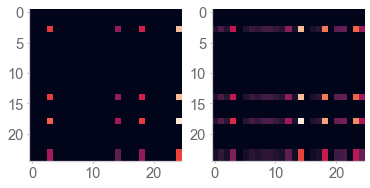

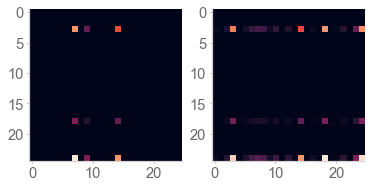

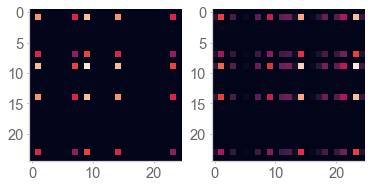

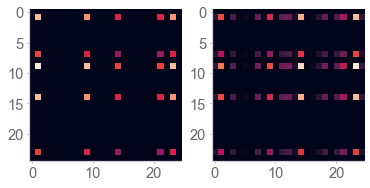

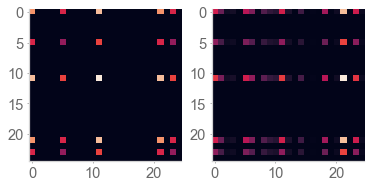

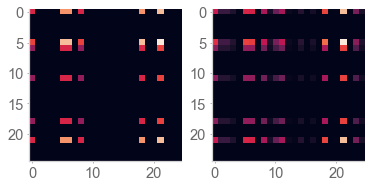

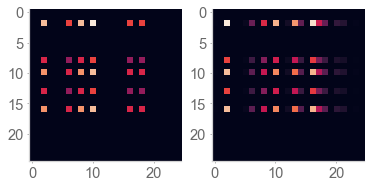

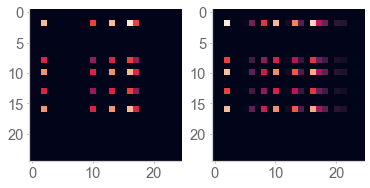

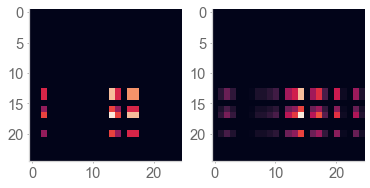

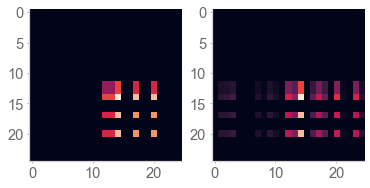

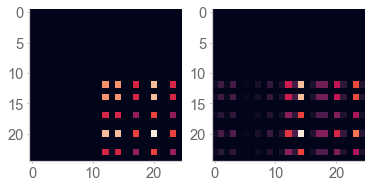

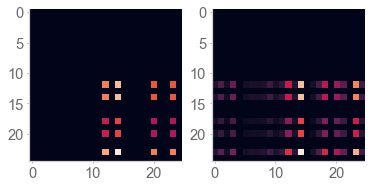

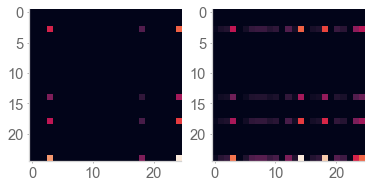

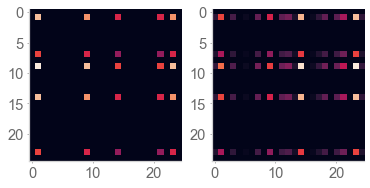

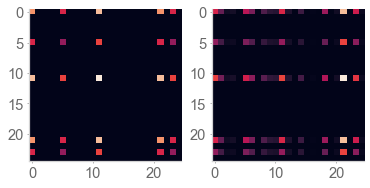

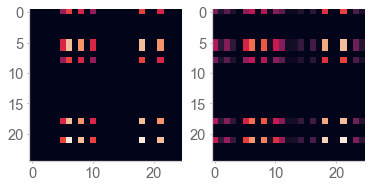

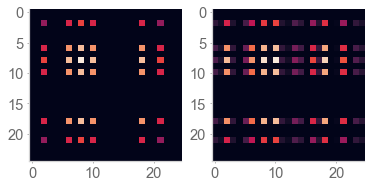

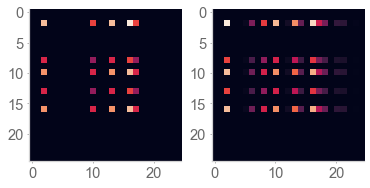

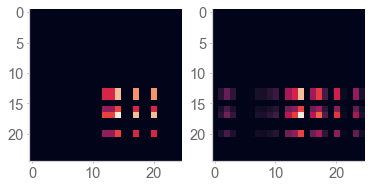

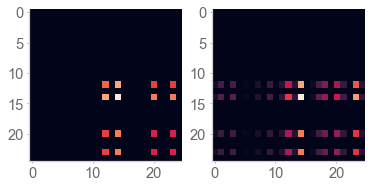

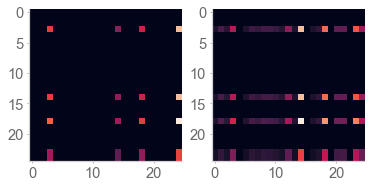

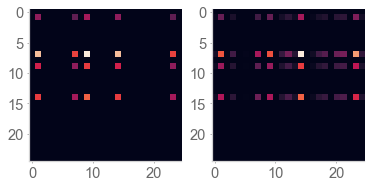

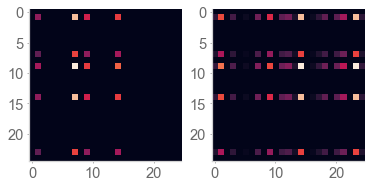

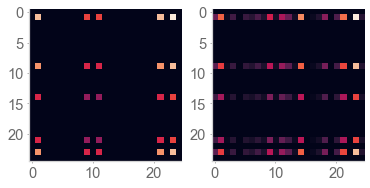

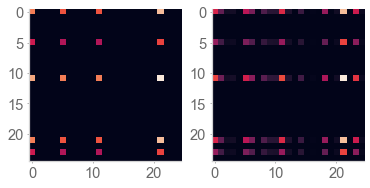

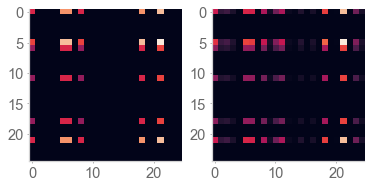

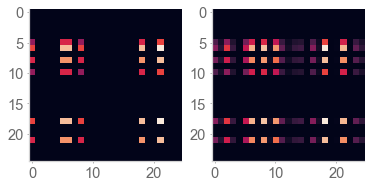

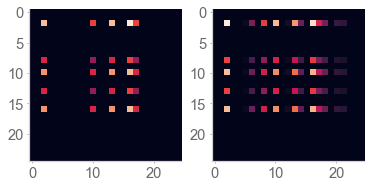

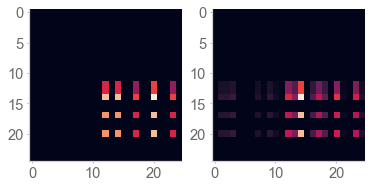

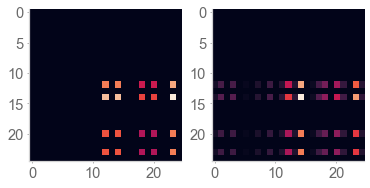

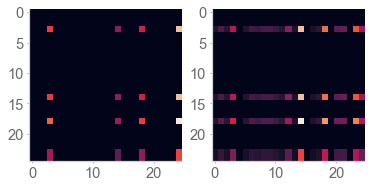

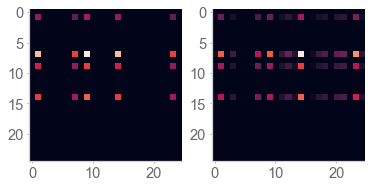

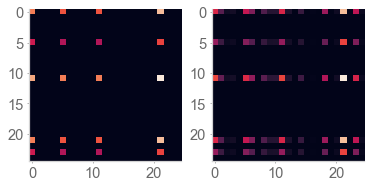

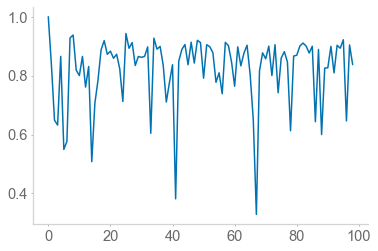





None_None.p


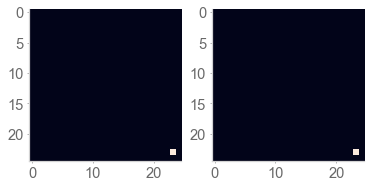

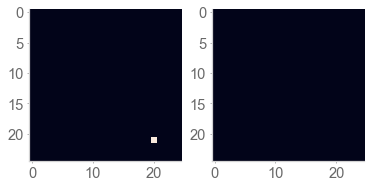

/Users/chingfang/opt/anaconda3/envs/aronov/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


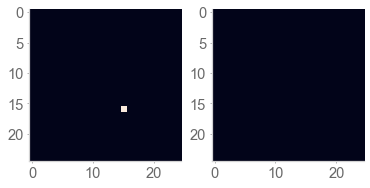

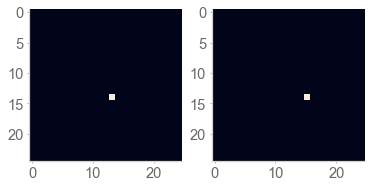

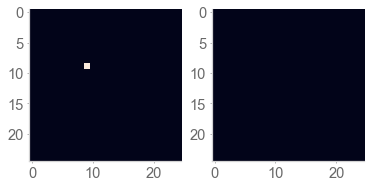

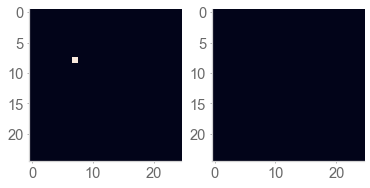

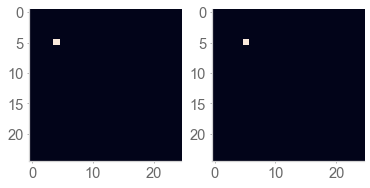

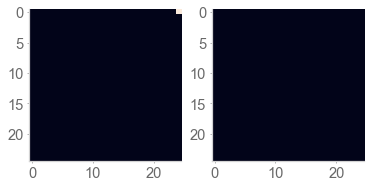

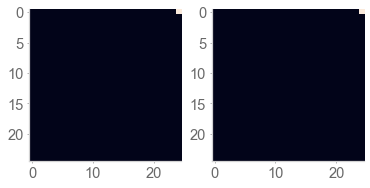

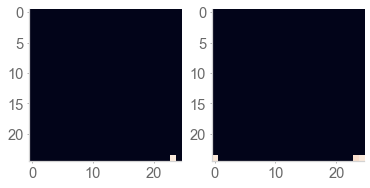

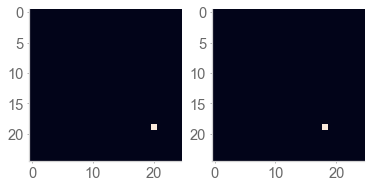

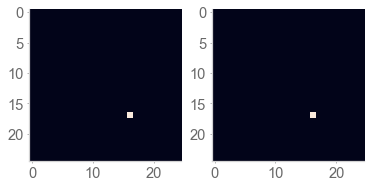

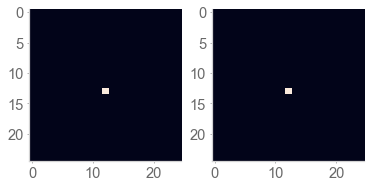

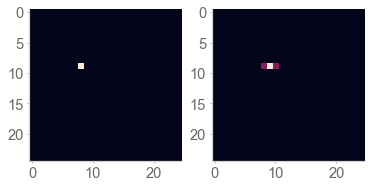

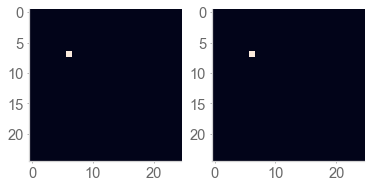

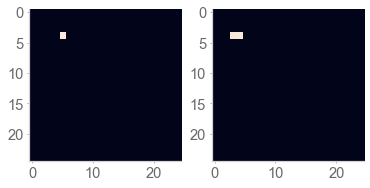

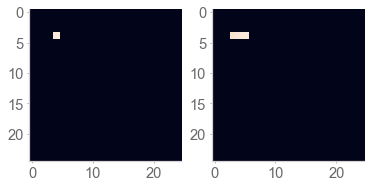

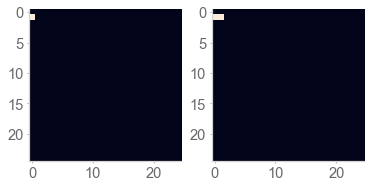

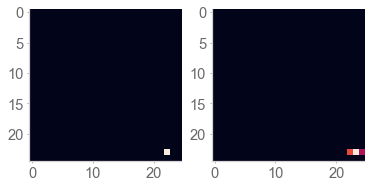

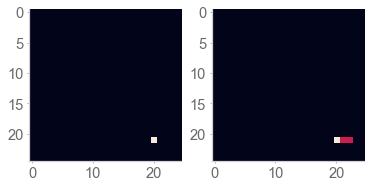

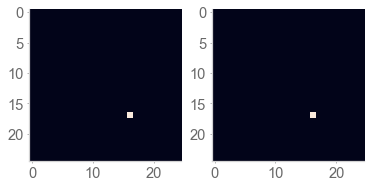

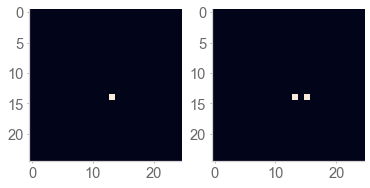

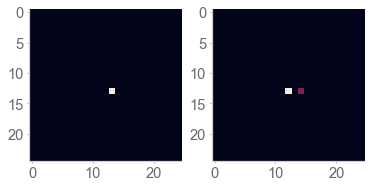

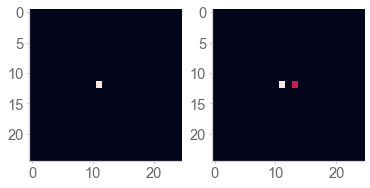

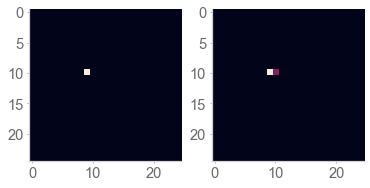

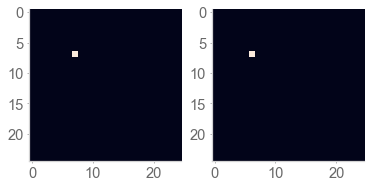

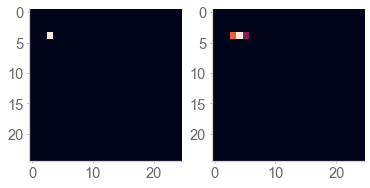

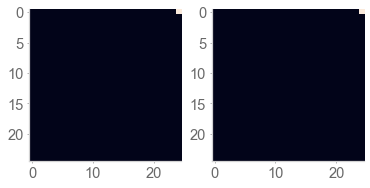

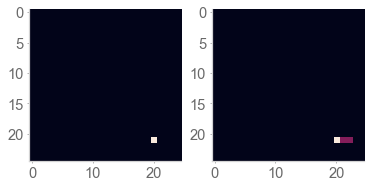

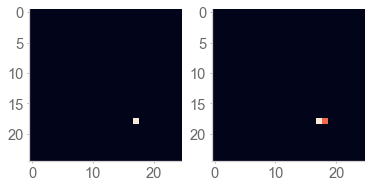

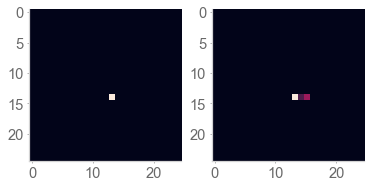

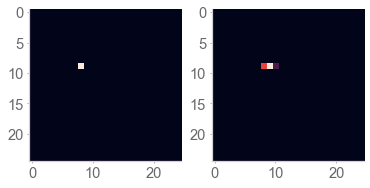

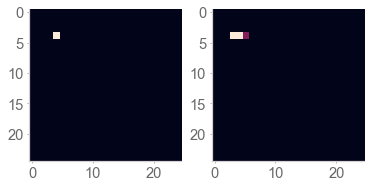

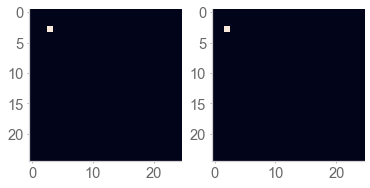

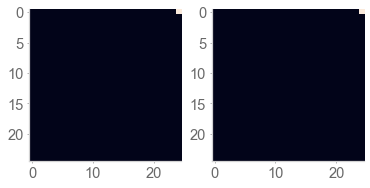

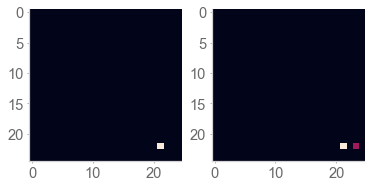

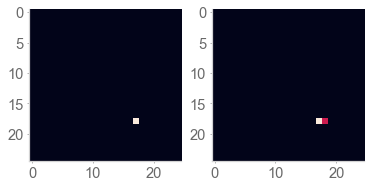

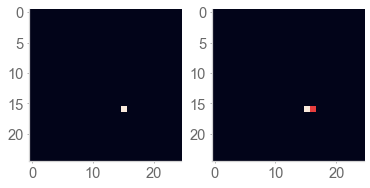

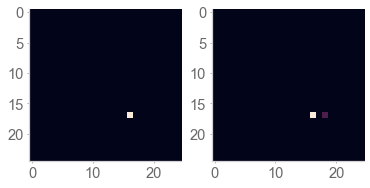

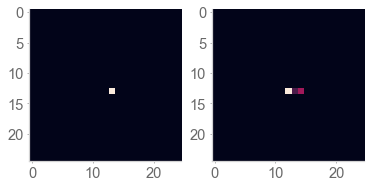

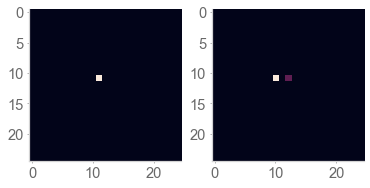

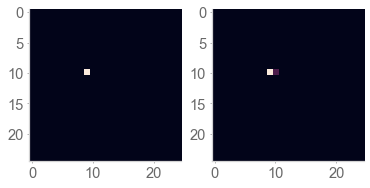

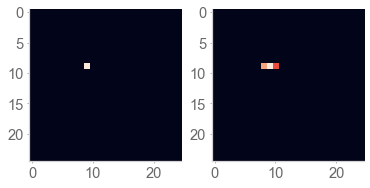

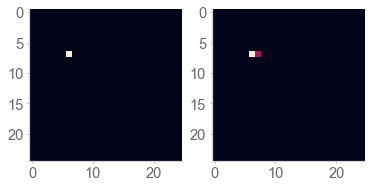

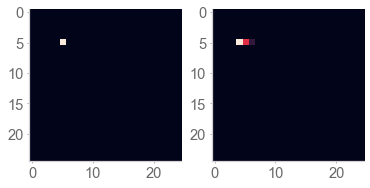

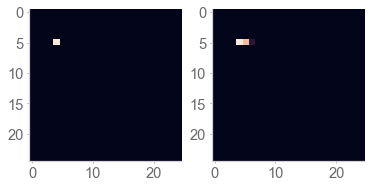

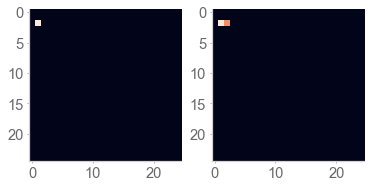

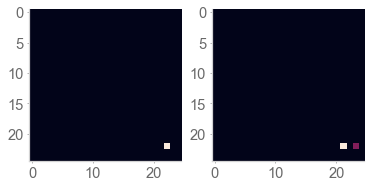

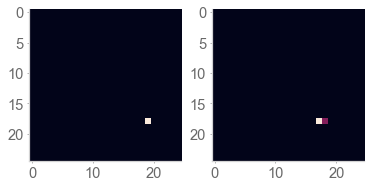

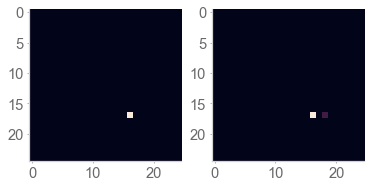

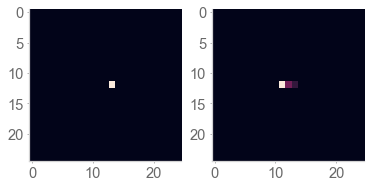

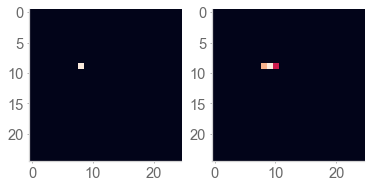

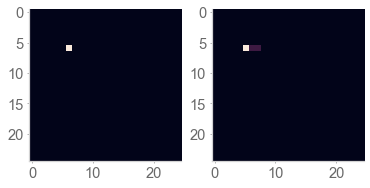

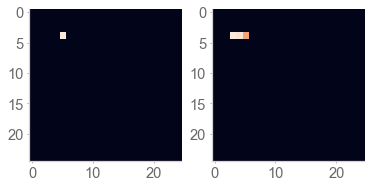

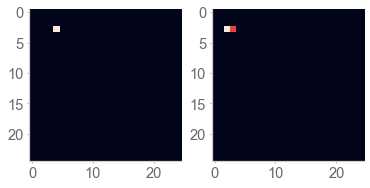

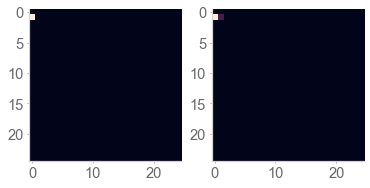

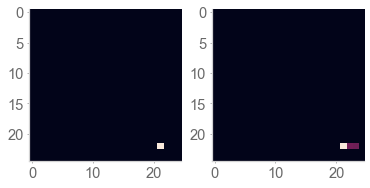

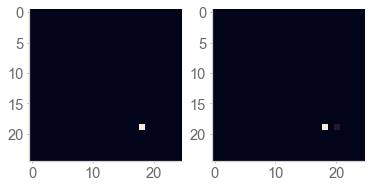

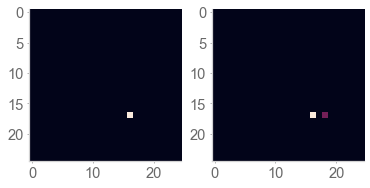

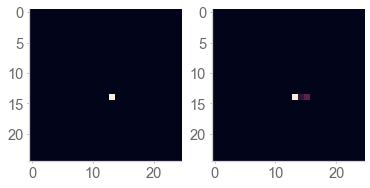

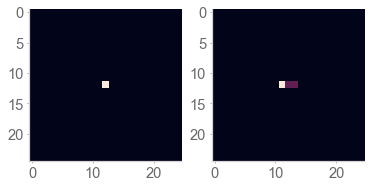

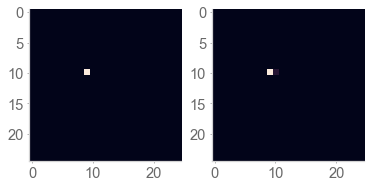

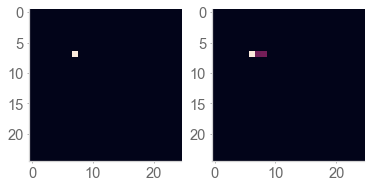

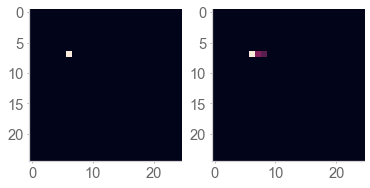

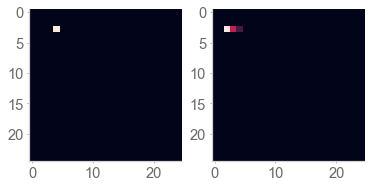

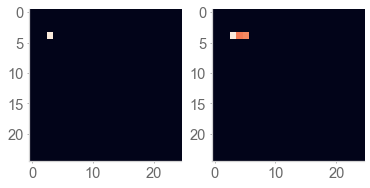

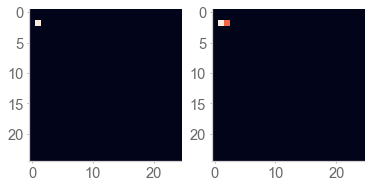

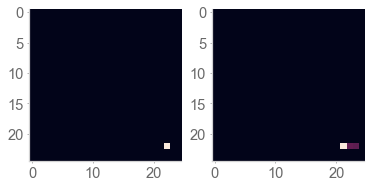

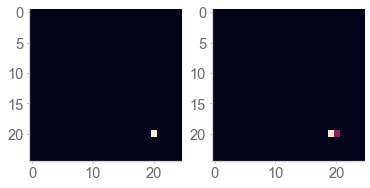

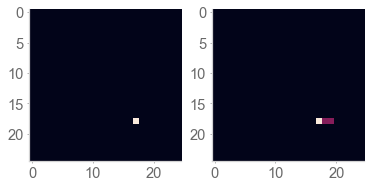

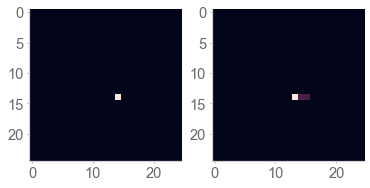

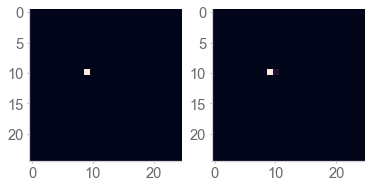

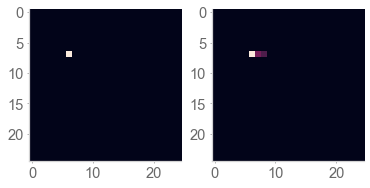

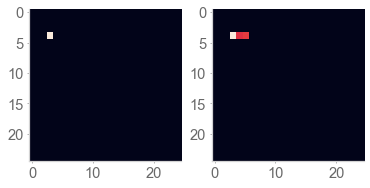

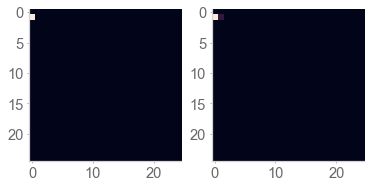

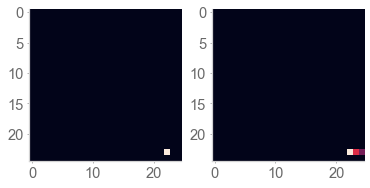

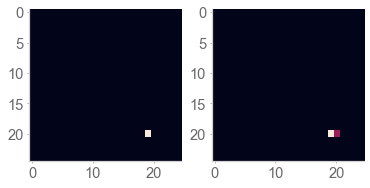

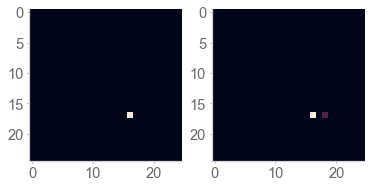

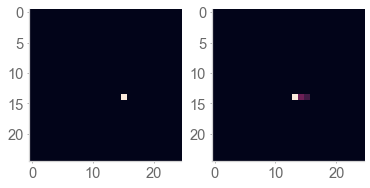

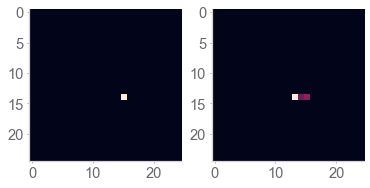

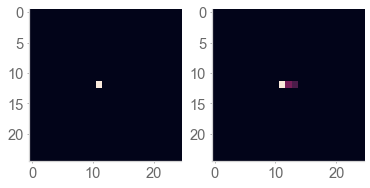

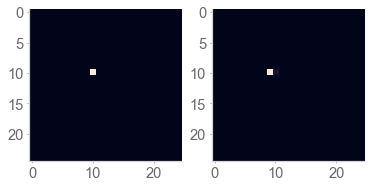

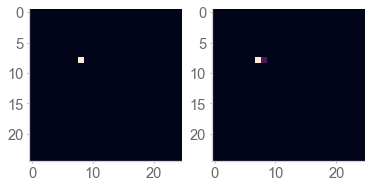

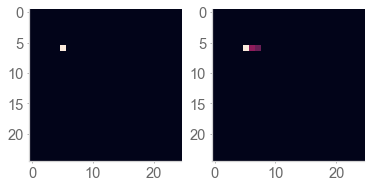

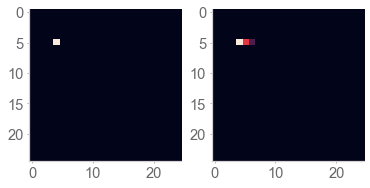

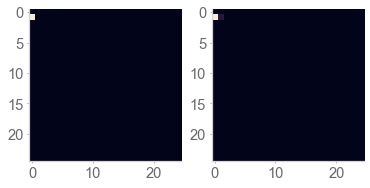

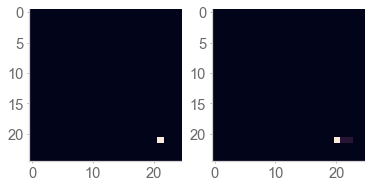

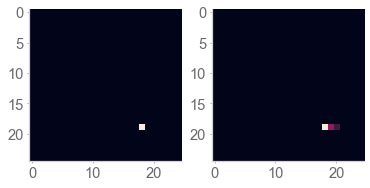

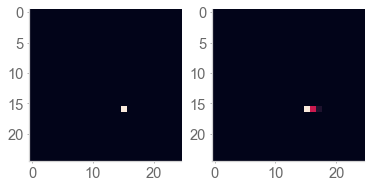

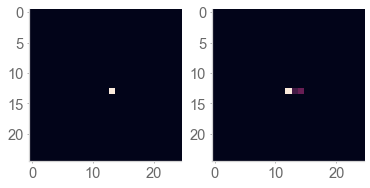

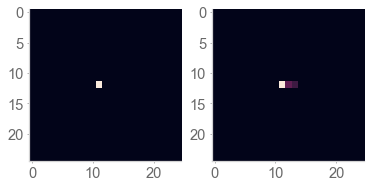

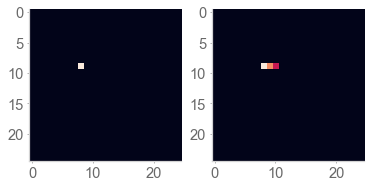

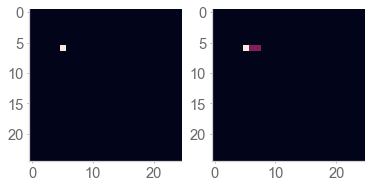

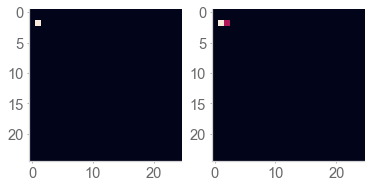

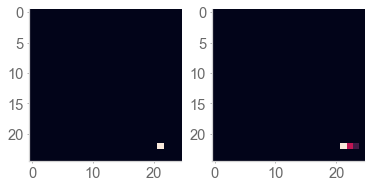

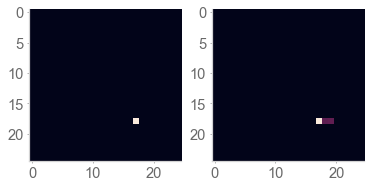

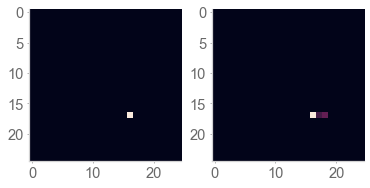

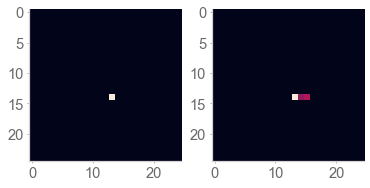

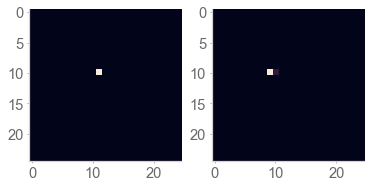

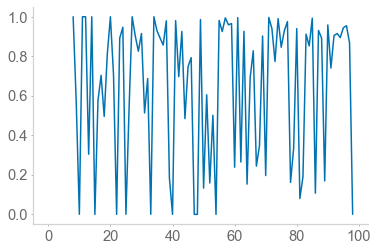

In [65]:
for p_file in p_files:
    print(p_file)
    with open(f'{exp_dir}{p_file}', 'rb') as f:
        results = pickle.load(f)['saved_grads']
    steps = results[0]['steps_mat']
    updates = results[0]['update_mat']
    forgets = results[0]['forget_mat']
    aligns = []
    for step, update, forget in zip(steps, updates, forgets):
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(update)
        axs[1].imshow(forget)
        plt.show()
        r, _ = pearsonr(update.flatten(), forget.flatten())
        aligns.append(r)
    plt.figure()
    plt.plot(aligns)
    plt.show()
    print('\n\n\n')

0.01_2.0.p


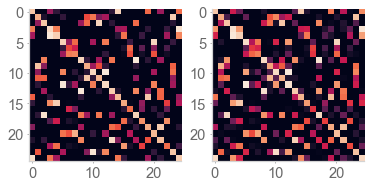

0.03_1.0.p


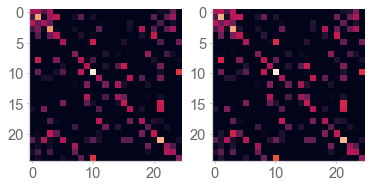

0.01_1.0.p


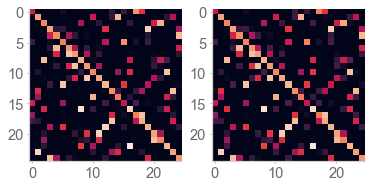

0.03_2.0.p


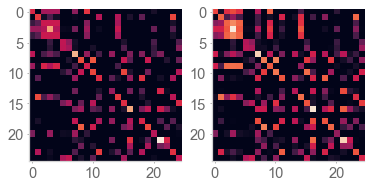

None_None.p


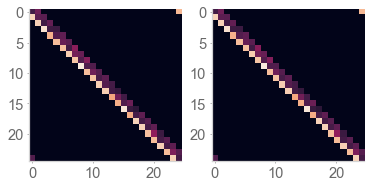

In [88]:
for p_file in p_files:
    print(p_file)
    with open(f'{exp_dir}{p_file}', 'rb') as f:
        results = pickle.load(f)['saved_grads']
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(results[0]['J_mat'])
    axs[1].imshow(results[0]['oja_J_mat'])
    plt.show()